In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, make_scorer, \
f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import gensim
from gensim.utils import simple_preprocess

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import pickle

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
with open('data/df.pickle', 'rb') as f:
    df = pickle.load(f)
df

,medical_specialty,transcription,transcript_gensim,gensim_cleaned
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, leave, atrial, enlargement, leave, atri...","[mode, leave, atrial, enlargement, leave, atri..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[leave, ventricular, cavity, size, wall, thick...","[leave, ventricular, cavity, size, wall, thick..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, normal, cardiac, chamber, size, ...","[description, normal, cardiac, chamber, size, ..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, history, prese...","[chief, complaint, chest, pain, history, prese..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[history, present, illness, patient, year, old...","[history, present, illness, patient, year, old..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[history, present, illness, mr, abc, year, old...","[history, present, illness, mr, abc, year, old..."


In [3]:
def num_ngrams(dictionary):
    words = list(dictionary.token2id.keys())
    ngrams = [word for word in words if '_' in word]
    print('Number of ngrams: ', len(ngrams))
    
def observe_ngrams(df,count=int,thresh=int):
    bigram_phrases = gensim.models.phrases.Phrases(df['gensim_cleaned'], min_count=count, threshold=thresh)
    trigram_phrases = gensim.models.phrases.Phrases(bigram_phrases[df['gensim_cleaned']],min_count=count,threshold=thresh)

    bigrams = gensim.models.phrases.Phraser(bigram_phrases)
    trigrams = gensim.models.phrases.Phraser(trigram_phrases)
    
    ngrammed = df['gensim_cleaned'].apply(lambda x: trigrams[bigrams[x]])
    
    ngram_dict = gensim.corpora.Dictionary(ngrammed)
    print('Length of dictionary: ', len(ngram_dict))
    num_ngrams(ngram_dict)
    return ngrammed, ngram_dict

In [4]:
ngrammed, ngram_dict = observe_ngrams(df,count=25,thresh=10)

Length of dictionary:  17458
Number of ngrams:  2114


In [5]:
words = list(ngram_dict.token2id.keys())
ngrams = [word for word in words if '_' in word]
ngrams

['aortic_valve',
 'atrial_enlargement',
 'ejection_fraction',
 'leave_ventricle',
 'leave_ventricular',
 'lv_systolic',
 'mitral_valve',
 'pericardial_effusion',
 'systolic_pressure',
 'tricuspid_regurgitation',
 'tricuspid_valve',
 'aortic_root',
 'leave_atrium',
 'mild_mitral_regurgitation',
 'pressure_mmhg',
 'pulmonary_artery',
 'right_atrium',
 'right_ventricle',
 'systolic_function',
 'wall_motion',
 'aortic_arch',
 'ascend_aorta',
 'coronary_artery',
 'descend_aorta',
 'leave_side',
 'mitral_regurgitation',
 'aortic_stenosis',
 'alert_orient',
 'cardiac_enzyme',
 'cerebral_angiogram',
 'ct_scan',
 'deny_tobacco',
 'discharge_home',
 'exam_bp_hr_rr',
 'exam_unremarkable',
 'facial_weakness',
 'fever_chill',
 'flexor_bilaterally',
 'full_strength',
 'illicit_drug',
 'illicit_drug_use',
 'mental_status',
 'migraine_headache',
 'nasolabial_fold',
 'nausea_vomit',
 'prior_admission',
 'prior_presentation',
 'pronator_drift',
 'pt_ptt',
 'reflexe_bue',
 'slur_speech',
 'squamous_cell'

In [6]:
corpus = [ngram_dict.doc2bow(doc) for doc in ngrammed]

In [7]:
ngrammed_df = ngrammed.to_frame()

vec = TfidfVectorizer(min_df=5,max_df=0.75)
ngrammed_vecd = vec.fit_transform(ngrammed_df['gensim_cleaned'].apply(lambda x: ' '.join(x)))
vecd_df = pd.DataFrame(ngrammed_vecd.todense(),columns=[word for word in vec.get_feature_names()])
display('Vectorized', vecd_df)

topic_model = NMF(n_components = 9)
topic_mat = topic_model.fit_transform(ngrammed_vecd)
topic_df = pd.DataFrame(topic_mat,columns = [f'topic {i+1}' for i in range(topic_model.n_components)])

display('NMF', pd.DataFrame(topic_df))

display('Combined', pd.concat([vecd_df,topic_df],axis=1))

'Vectorized'

,ab,abandon,abbreviate,abc,abcd,abcd_general,abcd_general_hospital,abcd_hospital,abd,abdomen,...,zofran,zoloft,zone,zonegran,zoster,zosyn,zygoma,zygomatic,zyprexa,zyrtec
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3710,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3711,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3712,0.0,0.0,0.0,0.076287,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'NMF'

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.000000,0.000000,0.048518,0.0,0.000000,0.0,0.000000,0.129747,0.0
1,0.000000,0.000000,0.066452,0.0,0.000000,0.0,0.000000,0.124983,0.0
2,0.000000,0.000000,0.060496,0.0,0.000000,0.0,0.000000,0.142658,0.0
3,0.000000,0.000000,0.020584,0.0,0.000000,0.0,0.000000,0.129330,0.0
4,0.000000,0.000000,0.050424,0.0,0.000799,0.0,0.000000,0.109550,0.0
...,...,...,...,...,...,...,...,...,...
3709,0.000000,0.004088,0.010934,0.0,0.000000,0.0,0.000000,0.080929,0.0
3710,0.000822,0.131158,0.002724,0.0,0.000000,0.0,0.000000,0.000000,0.0
3711,0.000409,0.111754,0.087885,0.0,0.000000,0.0,0.002337,0.002905,0.0
3712,0.000000,0.063526,0.091188,0.0,0.002461,0.0,0.000000,0.010961,0.0


'Combined'

,ab,abandon,abbreviate,abc,abcd,abcd_general,abcd_general_hospital,abcd_hospital,abd,abdomen,...,zyrtec,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.048518,0.0,0.000000,0.0,0.000000,0.129747,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.066452,0.0,0.000000,0.0,0.000000,0.124983,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.060496,0.0,0.000000,0.0,0.000000,0.142658,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.020584,0.0,0.000000,0.0,0.000000,0.129330,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.050424,0.0,0.000799,0.0,0.000000,0.109550,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.004088,0.010934,0.0,0.000000,0.0,0.000000,0.080929,0.0
3710,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000822,0.131158,0.002724,0.0,0.000000,0.0,0.000000,0.000000,0.0
3711,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000409,0.111754,0.087885,0.0,0.000000,0.0,0.002337,0.002905,0.0
3712,0.0,0.0,0.0,0.076287,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.063526,0.091188,0.0,0.002461,0.0,0.000000,0.010961,0.0


# Train-Test-Split

In [8]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(df['medical_specialty']))
mapping = dict(zip(range(len(le.classes_)), le.classes_))
y.value_counts()

7    1088
1     775
0     371
5     355
3     317
6     273
2     224
8     156
4     155
dtype: int64

In [9]:
X_train,X_test,y_train,y_test = train_test_split(ngrammed_df,y,random_state=42,stratify=y,test_size=0.2)

In [10]:
X_train

,gensim_cleaned
97,"[pelvic, tumor, cystocele, rectocele, postoper..."
3426,"[chief_complaint, rule, obstructive_sleep_apne..."
3160,"[admit, diagnosis, bleed, history_present_illn..."
1306,"[exam, right, foot, series, reason_exam, injur..."
1679,"[preoperative_diagnosis, low_back_pain, postop..."
...,...
3567,"[discharge_diagnosis, acute, respiratory_failu..."
681,"[diagnosis, term, pregnancy, possible, rupture..."
2054,"[title_operation, bilateral, endoscopic, proxi..."
880,"[preoperative_diagnosis, acute, abdominal_pain..."


In [11]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2971, 1) (743, 1)
(2971,) (743,)


In [12]:
y_train.value_counts()

7    870
1    620
0    297
5    284
3    254
6    218
2    179
8    125
4    124
dtype: int64

In [13]:
X_train['gensim_cleaned'] = X_train['gensim_cleaned'].apply(lambda x: ' '.join(x))
X_test['gensim_cleaned'] = X_test['gensim_cleaned'].apply(lambda x: ' '.join(x))

# Pipeline

In [14]:
vec = TfidfVectorizer(min_df=5,max_df=0.95)
nmf = NMF(n_components=9,random_state=42)

In [15]:
pd.DataFrame(vec.fit_transform(X_train['gensim_cleaned']).todense())

,0,1,2,3,4,5,6,7,8,9,...,9046,9047,9048,9049,9050,9051,9052,9053,9054,9055
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pd.DataFrame(Pipeline([('vec', vec), ('nmf', nmf)]).fit_transform(X_train['gensim_cleaned']))

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.000000,0.164813,0.000000,0.000000,0.000000,0.010332,0.016177
1,0.064300,0.000000,0.000000,0.001979,0.017697,0.000000,0.000000,0.010699,0.000000
2,0.074396,0.000000,0.000000,0.000000,0.009282,0.023498,0.000000,0.001980,0.000000
3,0.000000,0.069419,0.003261,0.000000,0.023025,0.000000,0.000000,0.048708,0.000000
4,0.000000,0.004658,0.017865,0.010756,0.000000,0.000441,0.091902,0.000000,0.011249
...,...,...,...,...,...,...,...,...,...
2966,0.077363,0.000000,0.013045,0.000000,0.000000,0.001823,0.000000,0.000000,0.019689
2967,0.014350,0.000000,0.000000,0.050826,0.010846,0.000000,0.000000,0.011022,0.000000
2968,0.000000,0.015427,0.041119,0.038596,0.017464,0.002306,0.002898,0.000000,0.013482
2969,0.055942,0.000000,0.002536,0.079315,0.000000,0.010290,0.000000,0.018495,0.016243


In [17]:
transformer_list = [('vec', TfidfVectorizer(min_df=5,max_df=0.95)), 
                    ('topics', Pipeline([
                        ('vec',TfidfVectorizer(min_df=5,max_df=0.95)),
                        ('nmf',NMF(n_components=9))]))]

feat_union = FeatureUnion(transformer_list) 
feat_union

FeatureUnion(transformer_list=[('vec', TfidfVectorizer(max_df=0.95, min_df=5)),
                               ('topics',
                                Pipeline(steps=[('vec',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=5)),
                                                ('nmf',
                                                 NMF(n_components=9))]))])

In [18]:
pd.DataFrame(feat_union.fit_transform(X_train['gensim_cleaned']).todense())

,0,1,2,3,4,5,6,7,8,9,...,9055,9056,9057,9058,9059,9060,9061,9062,9063,9064
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057005,...,0.0,0.000000,0.000000,0.000000,0.164418,0.000000,0.000000,0.000000,0.010326,0.016589
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082692,...,0.0,0.064454,0.000000,0.000000,0.001974,0.017705,0.000000,0.000000,0.010692,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.074574,0.000000,0.000000,0.000000,0.009287,0.023488,0.000000,0.001978,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.069640,0.003255,0.000000,0.023035,0.000000,0.000000,0.048675,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.004672,0.017831,0.010732,0.000000,0.000442,0.091575,0.000000,0.011539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.077548,0.000000,0.013021,0.000000,0.000000,0.001823,0.000000,0.000000,0.020203
2967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.014384,0.000000,0.000000,0.050701,0.010851,0.000000,0.000000,0.011015,0.000000
2968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.015475,0.041040,0.038505,0.017472,0.002305,0.002887,0.000000,0.013832
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037114,...,0.0,0.056076,0.000000,0.002531,0.079128,0.000000,0.010287,0.000000,0.018484,0.016655


# Functions for evaluating GridSearchCV

In [19]:
def evaluate_best(grid):
    grid.fit(X_train['gensim_cleaned'],y_train)
    best_params = grid.best_params_
    
    print(best_params)
    print('-----------------')
    
    best_estim = grid.best_estimator_
    
    cv = pd.DataFrame(grid.cv_results_)
    best_cv = cv[cv['params']==grid.best_params_]
    
    
    train_preds = best_estim.predict(X_train['gensim_cleaned'])
    test_preds = best_estim.predict(X_test['gensim_cleaned'])
    
    precision_tr,recall_tr,f1_tr,_ = precision_recall_fscore_support(y_train,train_preds,average='weighted',zero_division = 0)
    print('Training Accuracy: ', accuracy_score(y_train, train_preds))
    print('Training Precision: ', precision_tr)
    print('Training Recall: ', recall_tr)
    print('Training F1: ', f1_tr)
    print('-----------------')
    print('Cross-Validation Accuracy: ', best_cv['mean_test_accuracy'].values[0])
    print('Cross-Validation Precision: ', best_cv['mean_test_weighted_precision'].values[0])
    print('Cross-Validation Recall: ', best_cv['mean_test_weighted_recall'].values[0])
    print('Cross-Validation F1: ', best_cv['mean_test_weighted_f1'].values[0])
    print('-----------------')
    precision_te,recall_te,f1_te,_ = precision_recall_fscore_support(y_test,test_preds,average='weighted',zero_division = 0)
    print('Testing Accuracy: ', accuracy_score(y_test, test_preds))
    print('Testing Precision: ', precision_te)
    print('Testing Recall: ', recall_te)
    print('Testing F1: ', f1_te)
    
    return best_estim
    

In [20]:
def plot_confusion_matrices(best_estim):
    sns.set_style('dark')
    fig,ax = plt.subplots(2,1, figsize=(14,30))
    
    plot_confusion_matrix(best_estim,X_train['gensim_cleaned'],y_train,
                          display_labels=mapping.values(),xticks_rotation='vertical',
                         cmap='cividis',ax=ax[0],values_format='d')
    ax[0].set_title('Training Confusion Matrix')
    
    plot_confusion_matrix(best_estim,X_test['gensim_cleaned'],y_test,
                      display_labels=mapping.values(),xticks_rotation='vertical',
                     cmap='cividis',ax=ax[1],values_format='d')
    ax[1].set_title('Testing Confusion Matrix');

In [21]:
def evaluate_grid(grid):
    best_estim = evaluate_best(grid)
    plot_confusion_matrices(best_estim)
    return best_estim

# GridSearchCV

In [24]:
scoring = {
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'weighted_precision': make_scorer(precision_score, average='weighted',zero_division=0),
    'weighted_recall': make_scorer(recall_score, average='weighted',zero_division=0),
    'accuracy': 'accuracy'
}

In [25]:
transformer_list = [('vec', TfidfVectorizer()), 
                    ('topics', Pipeline([
                    ('vec',TfidfVectorizer()),
                    ('nmf',NMF(n_components=9,random_state=42))]))]

feat_union = FeatureUnion(transformer_list) 
feat_union

FeatureUnion(transformer_list=[('vec', TfidfVectorizer()),
                               ('topics',
                                Pipeline(steps=[('vec', TfidfVectorizer()),
                                                ('nmf',
                                                 NMF(n_components=9,
                                                     random_state=42))]))])

# LogisticRegression

In [26]:
vectorizers = [TfidfVectorizer(),CountVectorizer()]

In [27]:
log_pipe = Pipeline([('feat_union',feat_union),('model',LogisticRegression(random_state=42))])

log_params = {
    'feat_union__vec':vectorizers, 
    'feat_union__vec__min_df':[0.025], 
    'feat_union__vec__max_df':[0.75], 
    'feat_union__topics__vec__min_df':[5], 
    'feat_union__topics__vec__max_df':[0.75], 
    'feat_union__topics__nmf__l1_ratio':[0], 
    'feat_union__topics__nmf__max_iter':[10000], #no more convergence warnings
    'model__C': [0.1],
    'model__max_iter':[1000],
    'model__class_weight':['balanced'],
    'model__solver':['lbfgs']
}

log_grid = GridSearchCV(log_pipe,log_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 10000, 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': TfidfVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 1000, 'model__solver': 'lbfgs'}
-----------------
Training Accuracy:  0.56950521709862
Training Precision:  0.6088940911582034
Training Recall:  0.56950521709862
Training F1:  0.5523845578714417
-----------------
Cross-Validation Accuracy:  0.5223908553320319
Cross-Validation Precision:  0.552472284052806
Cross-Validation Recall:  0.5223908553320319
Cross-Validation F1:  0.5052197764059939
-----------------
Testing Accuracy:  0.5679676985195155
Testing Precision:  0.5944590870861892
Testing Recall:  0.5679676985195155
Testing F1:  0.5548333994499307


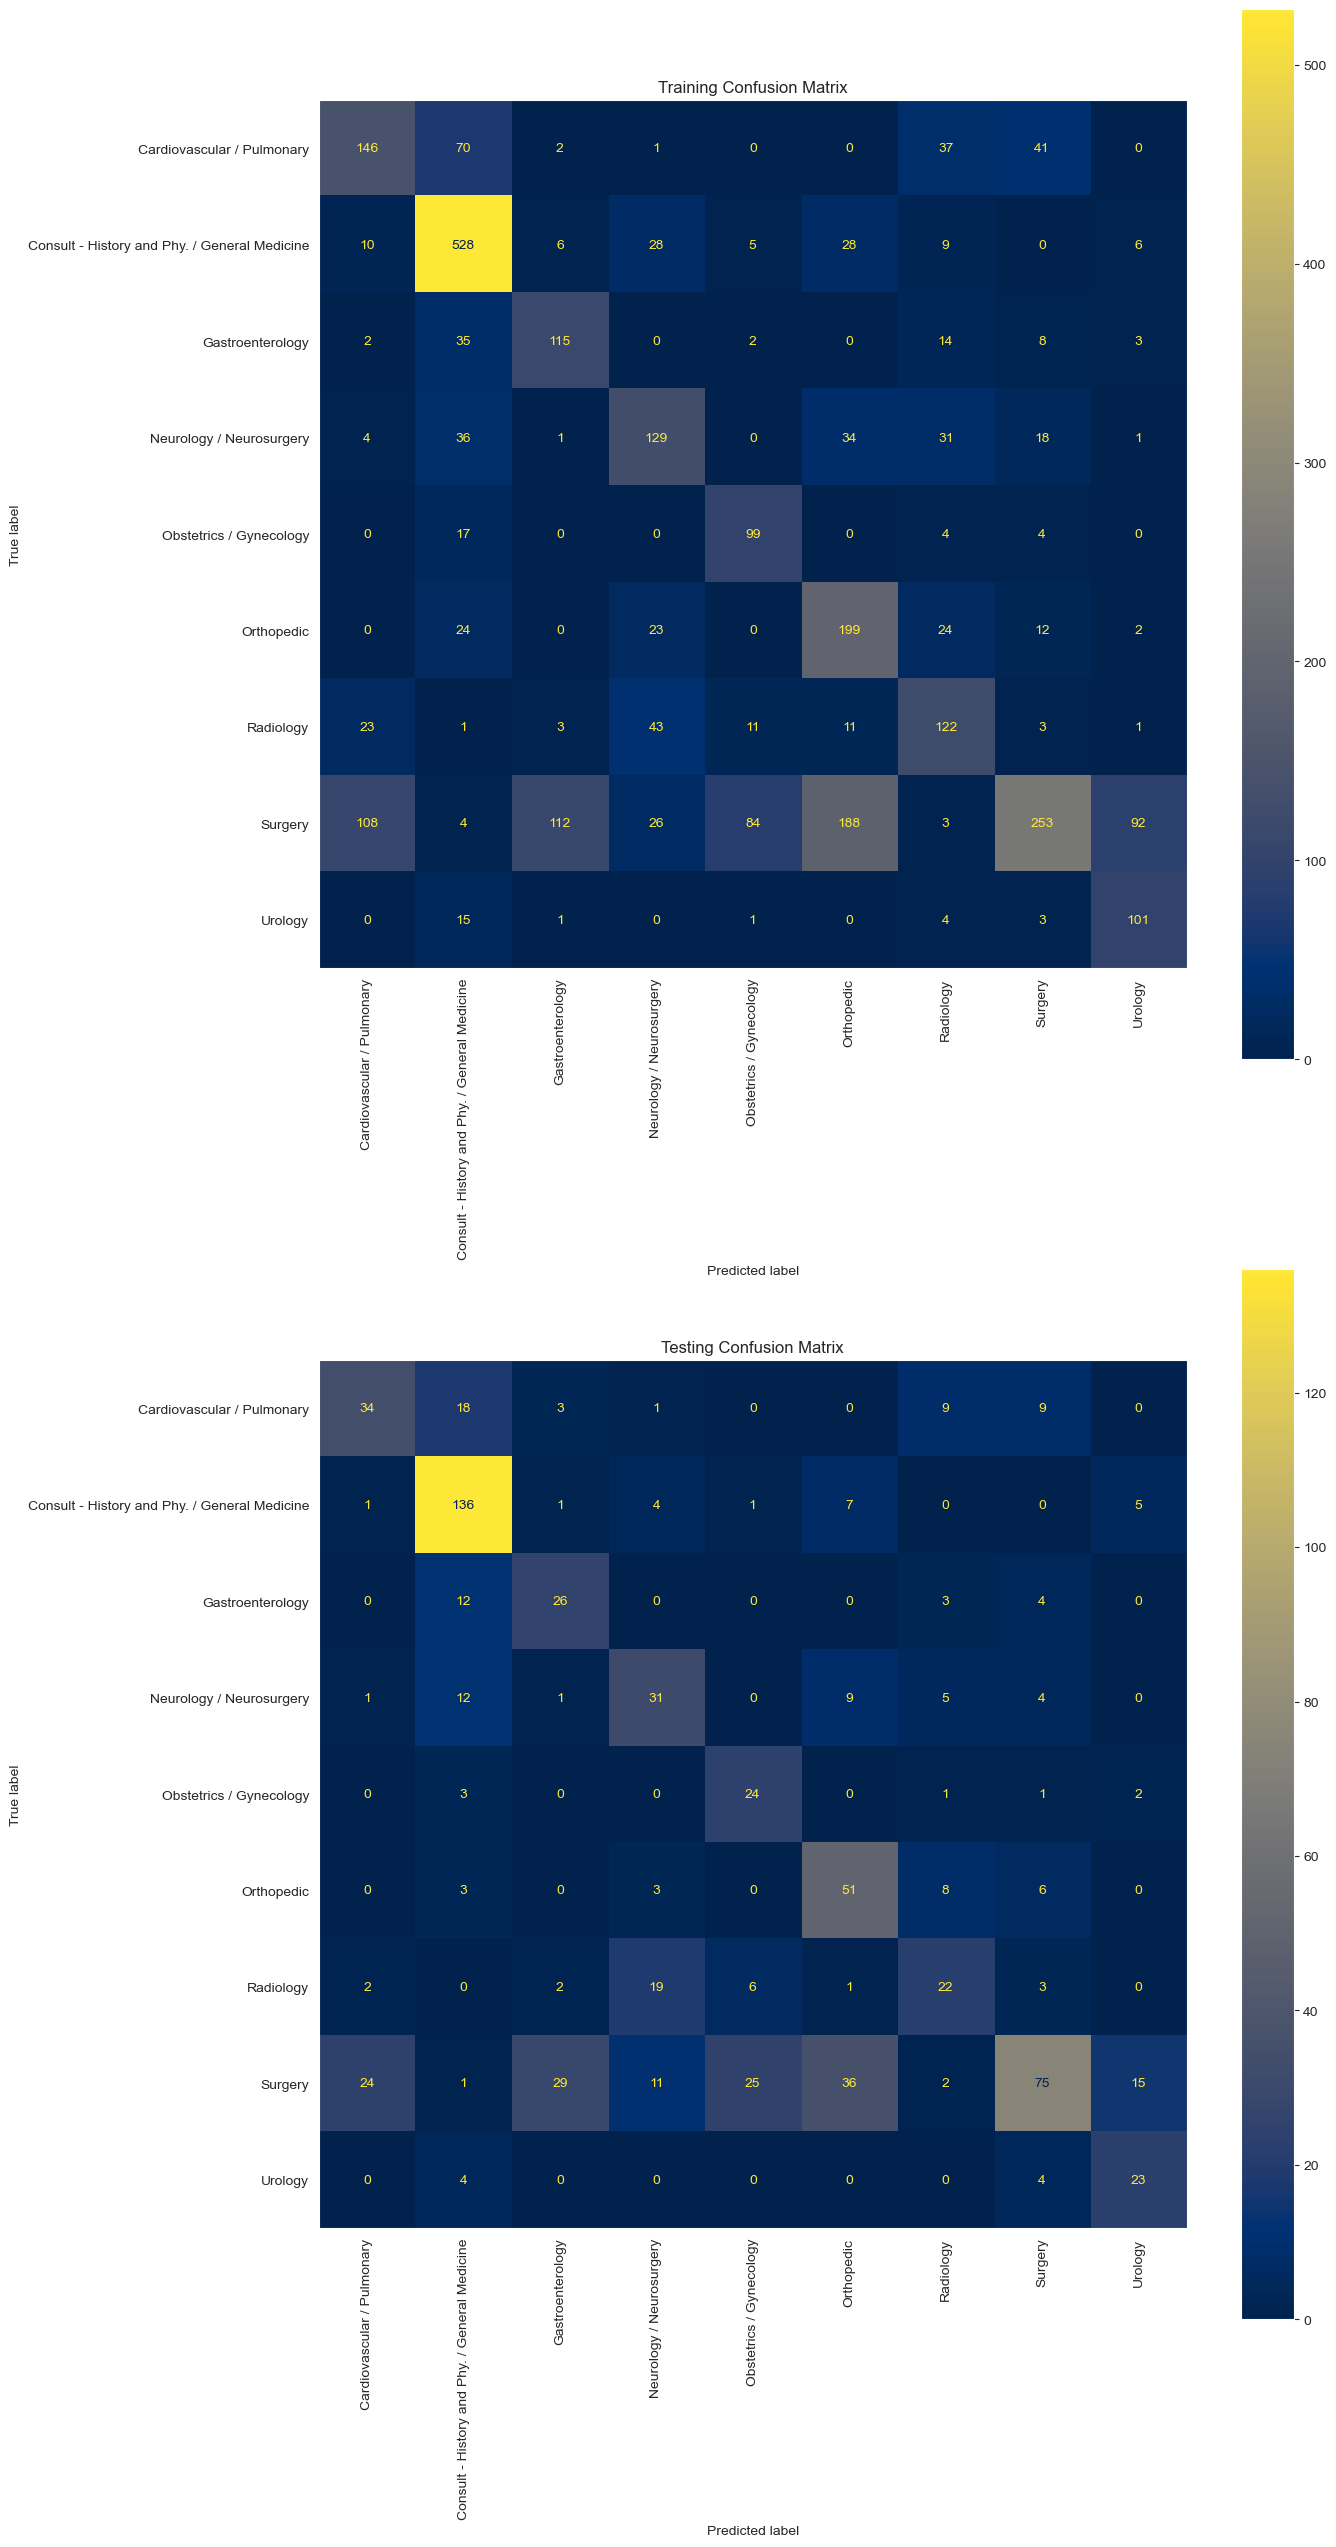

In [28]:
best_log = evaluate_grid(log_grid)

# MultinomialNB

In [572]:
mb_pipe = Pipeline([('feat_union',feat_union),('model',MultinomialNB())])

mb_params = {
    'feat_union__vec':vectorizers, #testing vectorizers
    'feat_union__vec__min_df':[0.025], #tried 0.025,0.05
    'feat_union__vec__max_df':[0.75], #tried 0.75,0.9,0.95
    'feat_union__topics__vec':vectorizers,
    'feat_union__topics__vec__min_df':[5,0.025], #tried 5, 0.025, 0.05
    'feat_union__topics__vec__max_df':[0.75, 0.95], # tried 0.75, 0.9, 0.95
    'feat_union__topics__nmf__l1_ratio':[0,0.2,0.3], #tried 0,0.1,0.2,0.3
    #'feat_union__topics__nmf__alpha_W':[0,0.1], leads to many warnings, i guess it ends up making topic weights null with any l1 reg.
    'feat_union__topics__nmf__max_iter':[1000], #no more convergence warnings
    'model__alpha': [0.05, 0.1] # tried 0.05, 0.1,0.5,1,2
}

mb_grid = GridSearchCV(mb_pipe,mb_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec': CountVectorizer(max_df=0.75, min_df=0.025), 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': CountVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__alpha': 0.1}
-----------------
Training Accuracy:  0.5846516324469876
Training Precision:  0.5894564902055508
Training Recall:  0.5846516324469876
Training F1:  0.5682530396290171
-----------------
Cross-Validation Accuracy:  0.5213813202048496
Cross-Validation Precision:  0.5117832334146304
Cross-Validation Recall:  0.5213813202048496
Cross-Validation F1:  0.5035857269963874
-----------------
Testing Accuracy:  0.5248990578734859
Testing Precision:  0.5184925400844053
Testing Recall:  0.5248990578734859
Testing F1:  0.5107765325305116


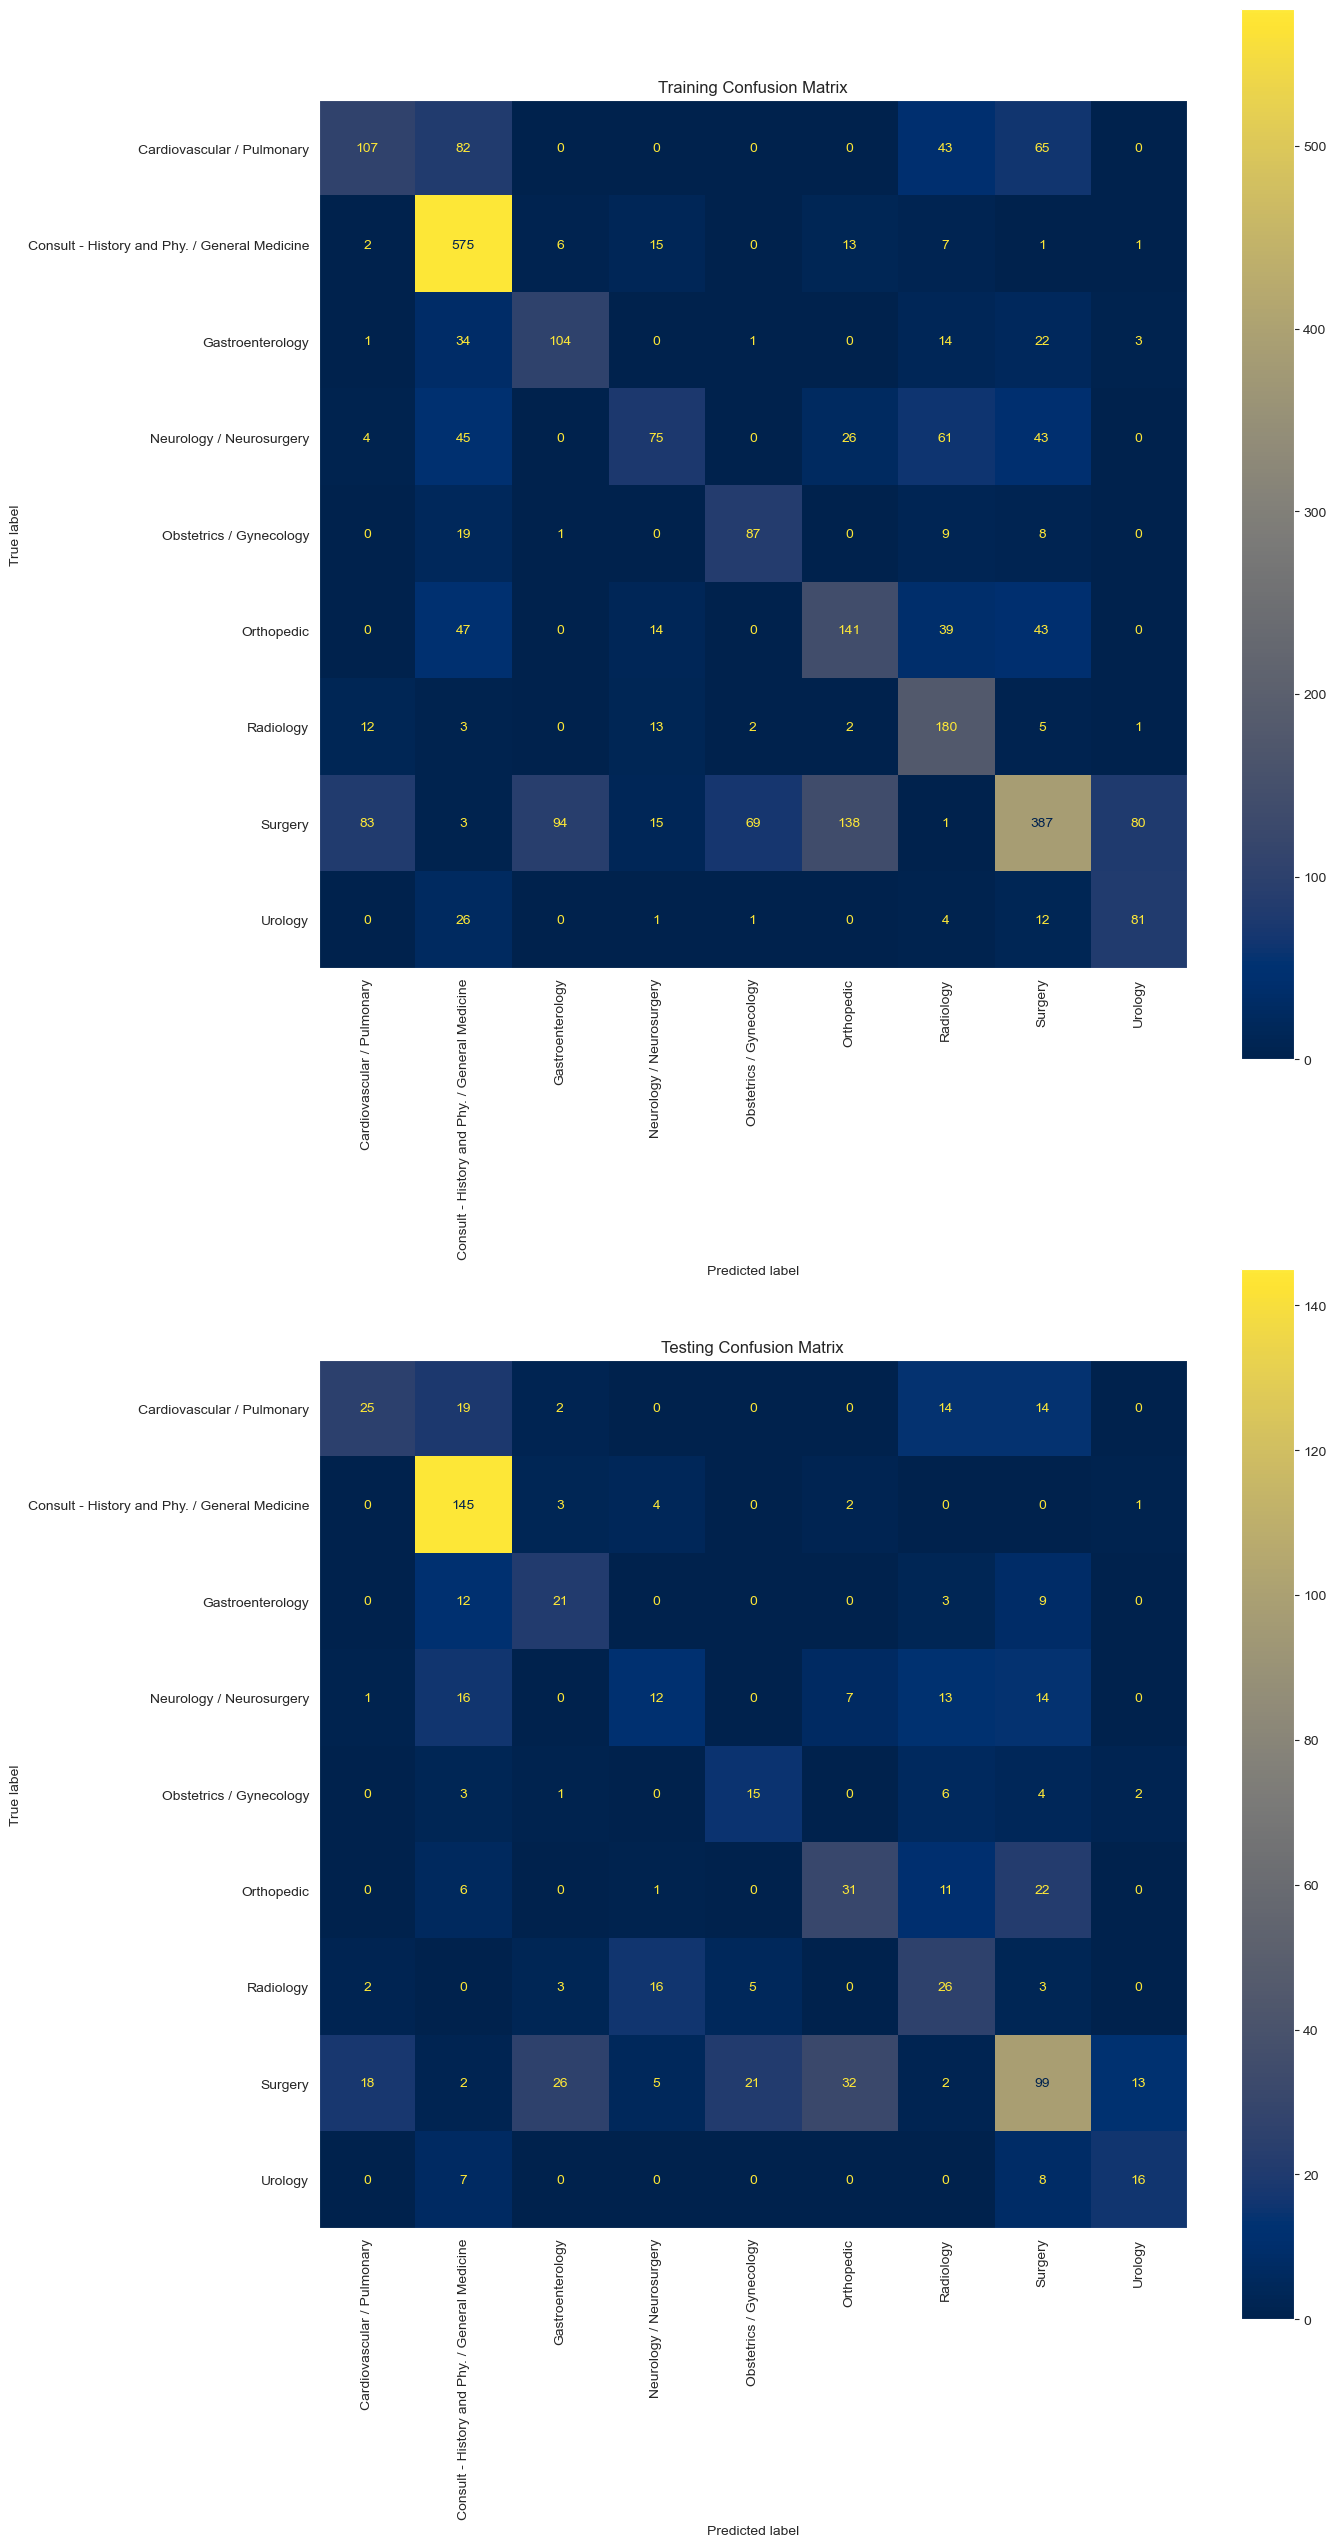

In [573]:
best_mb = evaluate_grid(mb_grid)

# ComplementNB

In [574]:
cb_pipe = Pipeline([('feat_union',feat_union),('model',ComplementNB())])

cb_params = {
    'feat_union__vec':vectorizers,
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec':vectorizers,
    'feat_union__topics__vec__min_df':[5,0.025], 
    'feat_union__topics__vec__max_df':[0.75, 0.95], 
    'feat_union__topics__nmf__l1_ratio':[0,0.2,0.3], 
    'feat_union__topics__nmf__max_iter':[1000],
    'model__alpha': [0.1,0.5] # tried 0.1,0.5,1,2
}

cb_grid = GridSearchCV(cb_pipe,cb_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec': TfidfVectorizer(max_df=0.75, min_df=0.025), 'feat_union__topics__vec__max_df': 0.95, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': TfidfVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__alpha': 0.1}
-----------------
Training Accuracy:  0.5607539548973409
Training Precision:  0.5431650440015576
Training Recall:  0.5607539548973409
Training F1:  0.4885737090284452
-----------------
Cross-Validation Accuracy:  0.535511982570806
Cross-Validation Precision:  0.48594454118959635
Cross-Validation Recall:  0.535511982570806
Cross-Validation F1:  0.4554048331101435
-----------------
Testing Accuracy:  0.5558546433378196
Testing Precision:  0.5427853940594641
Testing Recall:  0.5558546433378196
Testing F1:  0.4780502252375605


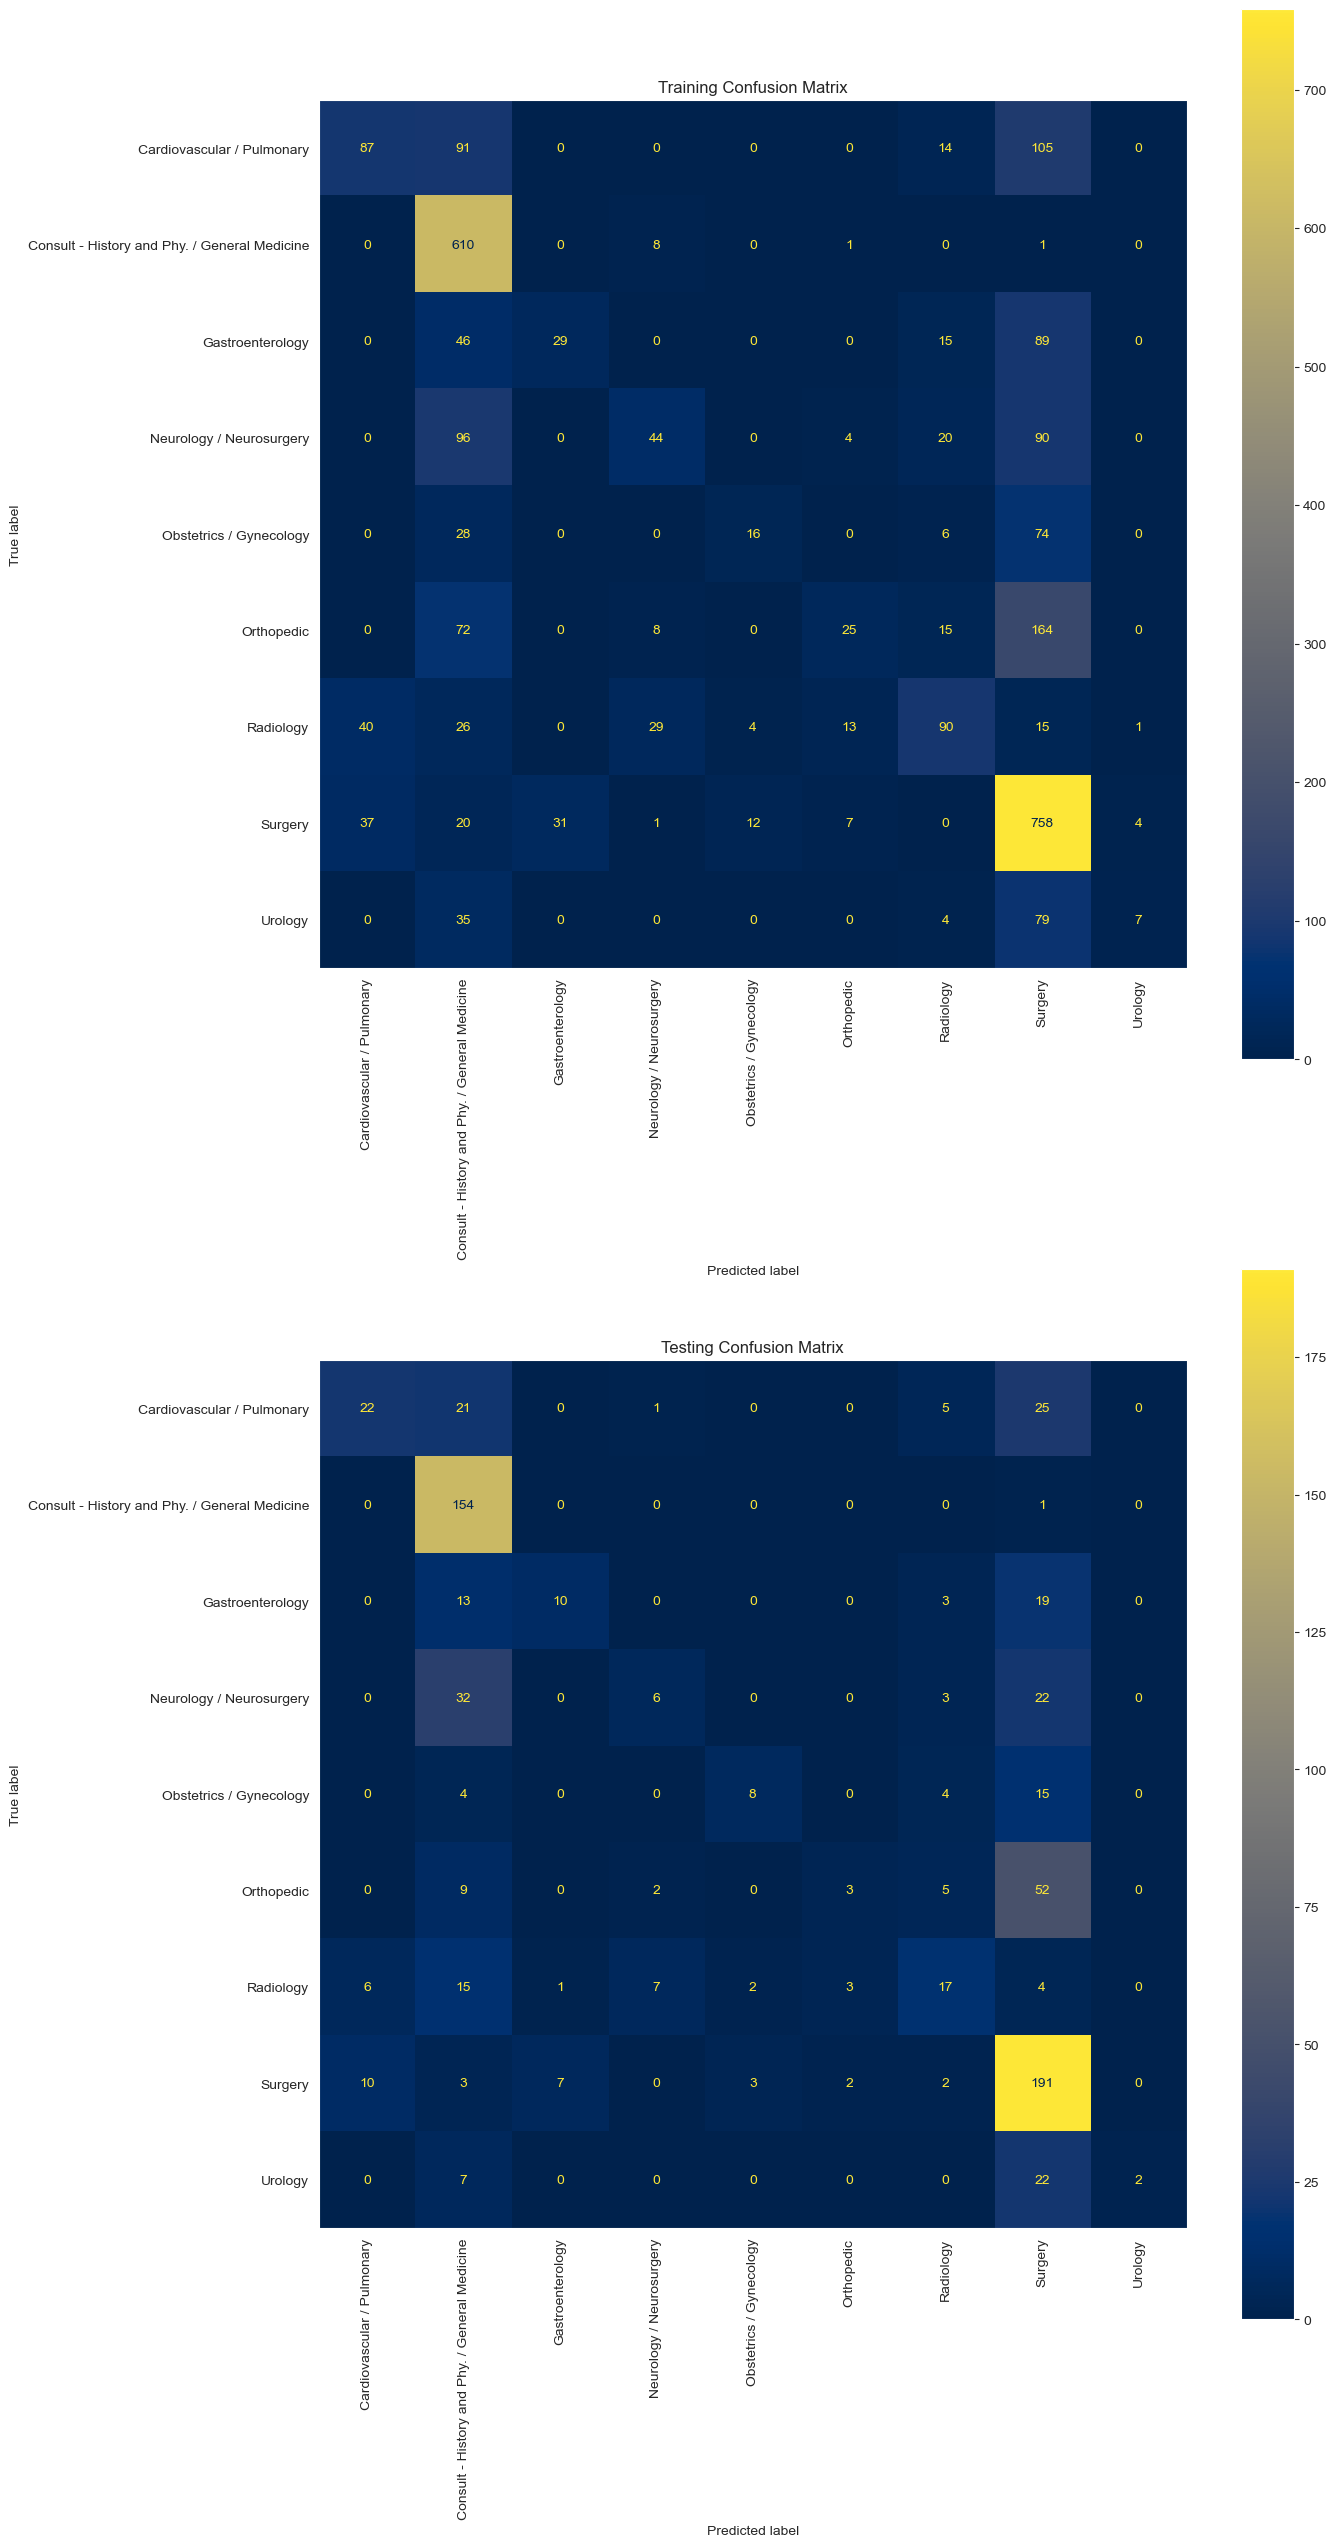

In [575]:
best_cb = evaluate_grid(cb_grid)

# Random Forest

In [576]:
rft_pipe = Pipeline([('feat_union',feat_union),('model',RandomForestClassifier(random_state=42))])

#min_samples_leaf
#max_features
#criterion
#max_depth

rft_params = {
    'feat_union__vec':vectorizers,
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec__min_df':[5],
    'feat_union__topics__vec__max_df':[0.75],
    'feat_union__topics__nmf__l1_ratio':[0],
    'feat_union__topics__nmf__max_iter':[1000],
    'model__n_estimators': [200,500],
    'model__max_depth':[3,4],
    'model__criterion':['entropy'], #entropy did better than gini
    'model__class_weight': ['balanced'] #helped a lot but scores still bad
}

rft_grid = GridSearchCV(rft_pipe,rft_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': CountVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__n_estimators': 500}
-----------------
Training Accuracy:  0.5365196903399528
Training Precision:  0.5546146588946472
Training Recall:  0.5365196903399528
Training F1:  0.5156884387554228
-----------------
Cross-Validation Accuracy:  0.5075839628780805
Cross-Validation Precision:  0.5193680642418584
Cross-Validation Recall:  0.5075839628780805
Cross-Validation F1:  0.48120386229586
-----------------
Testing Accuracy:  0.5329744279946165
Testing Precision:  0.5491373625750812
Testing Recall:  0.5329744279946165
Testing F1:  0.5132165357938052


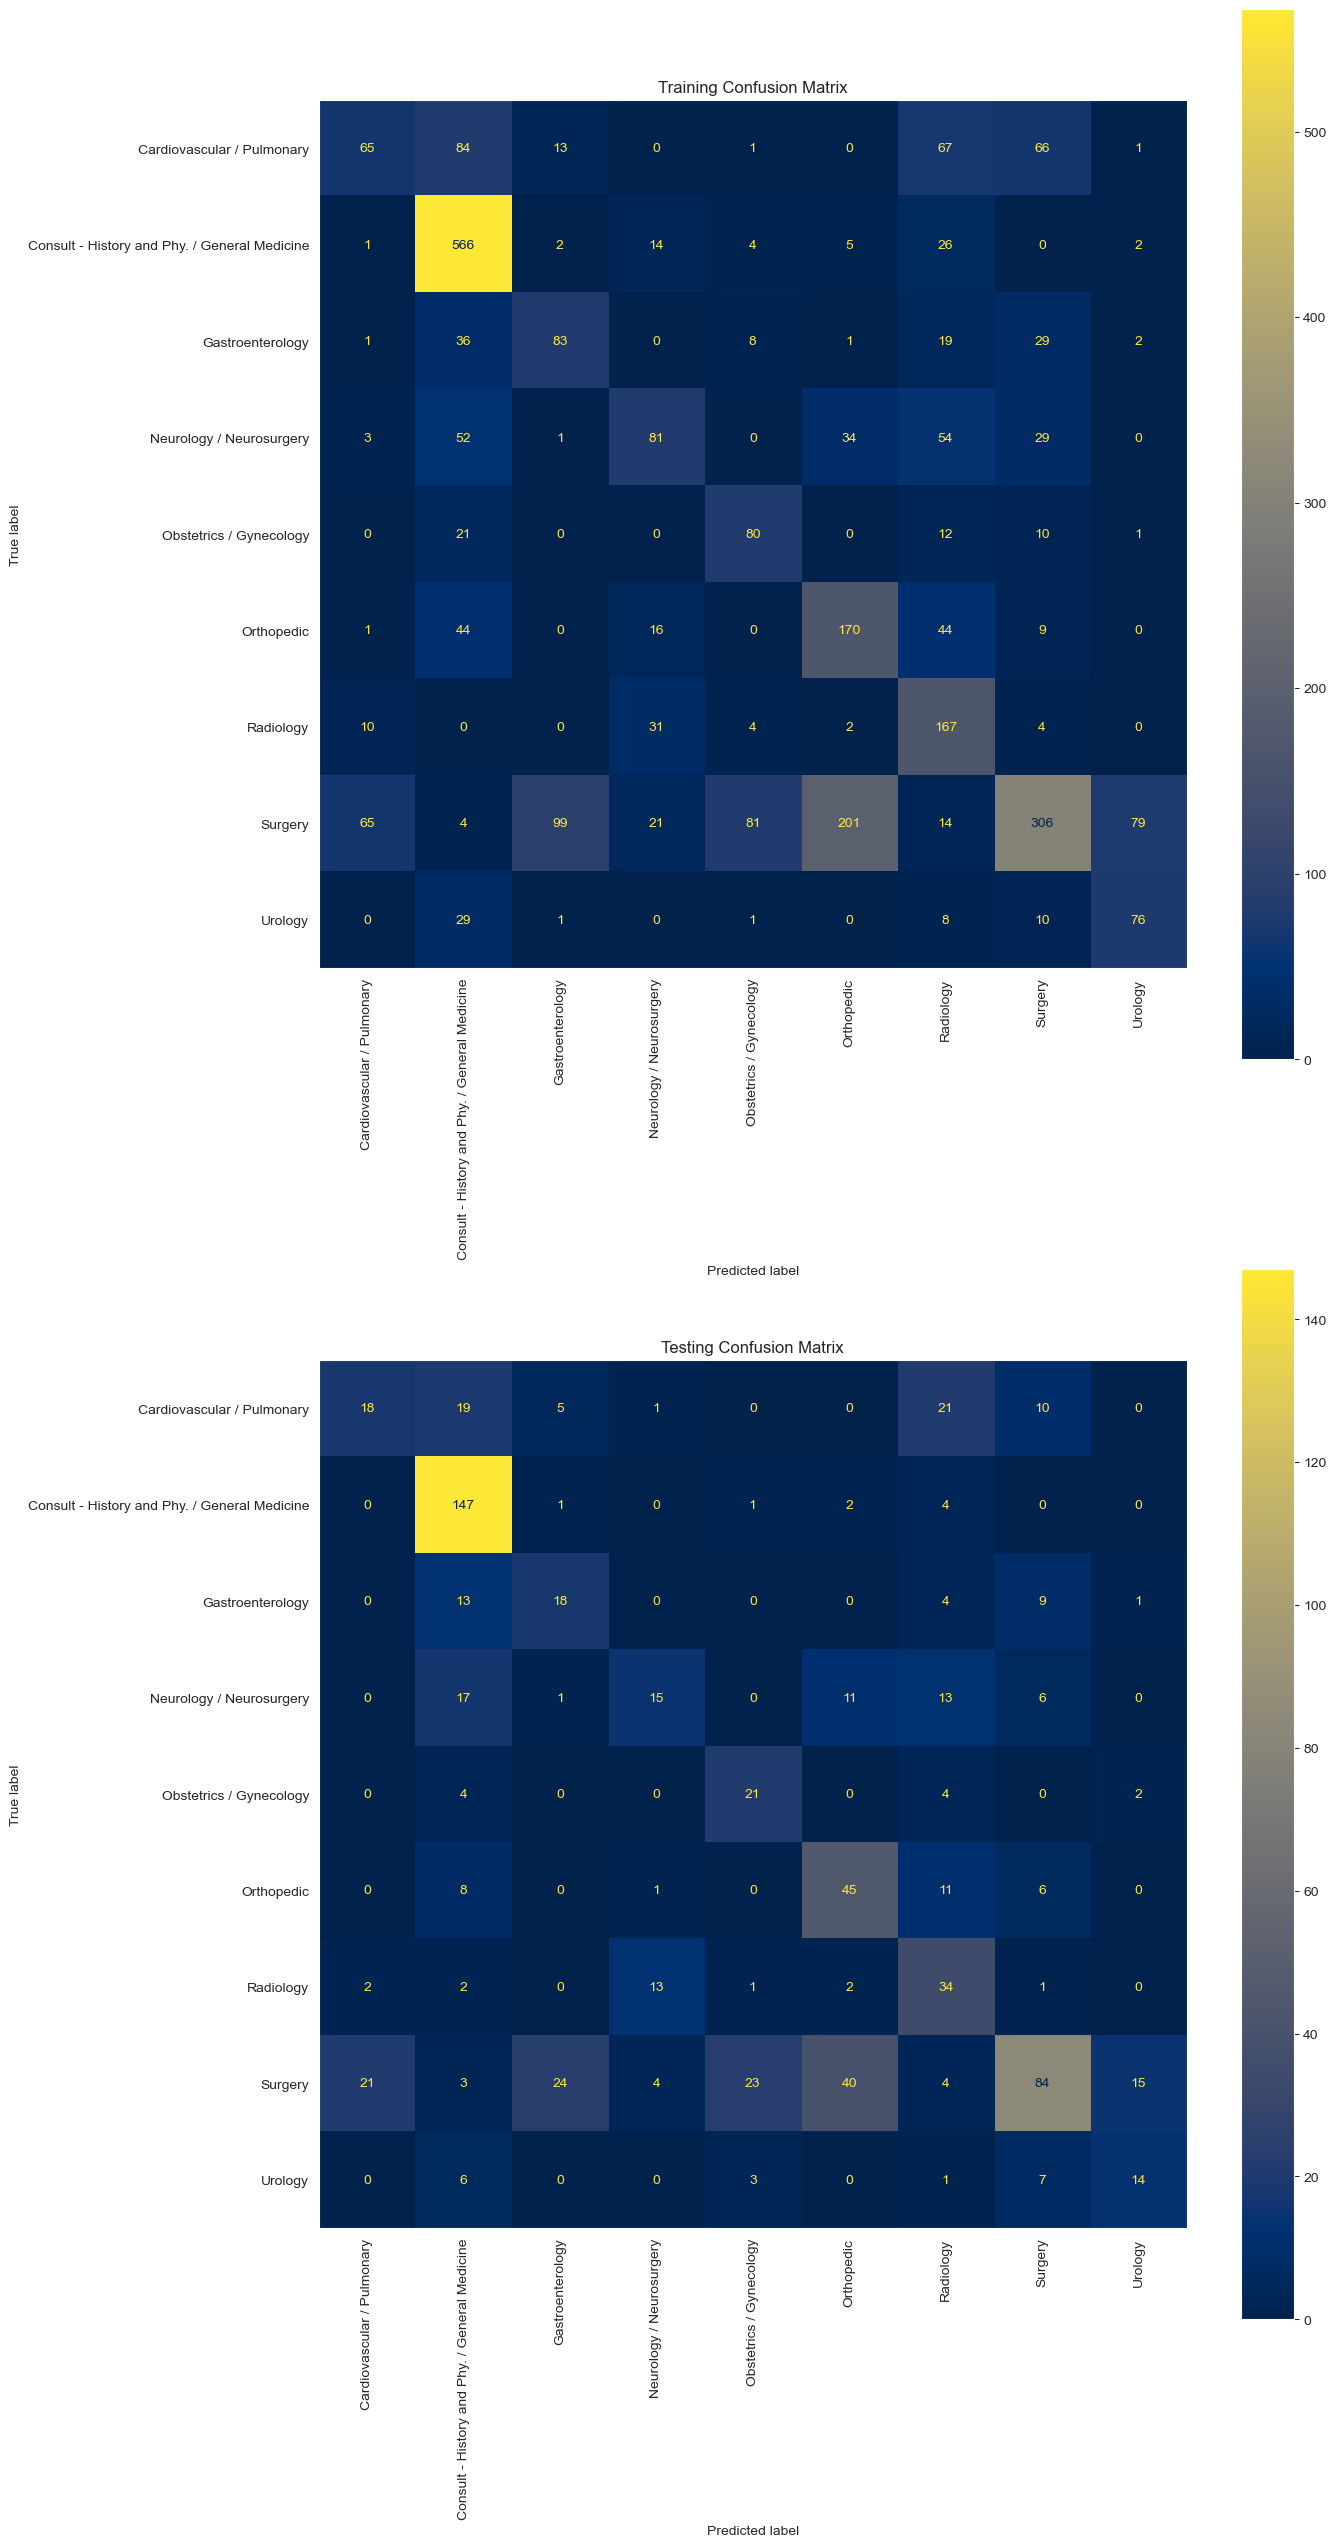

In [577]:
best_rft = evaluate_grid(rft_grid)

# Catboost

In [578]:
cat_pipe = Pipeline([('feat_union',feat_union),('model',CatBoostClassifier(random_state=42))])

cat_params = {
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec__min_df':[5],
    'feat_union__topics__vec__max_df':[0.75],
    'feat_union__topics__nmf__max_iter':[1000],
    'model__n_estimators': [100,200],
    'model__max_depth':[3,5],
    'model__learning_rate':[0.2,0.3],
    'model__colsample_bylevel': [0.75],
    'model__early_stopping_rounds':[10],
    'model__auto_class_weights': ['Balanced'],
    'model__l2_leaf_reg':[10],
    'model__boosting_type': ['Ordered']
}

cat_grid = GridSearchCV(cat_pipe,cat_params,cv=5,scoring=scoring,refit='weighted_f1')

0:	learn: 2.0951707	total: 678ms	remaining: 1m 7s
1:	learn: 2.0265102	total: 1.28s	remaining: 1m 2s
2:	learn: 1.9719728	total: 1.77s	remaining: 57.1s
3:	learn: 1.9421097	total: 2.21s	remaining: 53s
4:	learn: 1.8908889	total: 2.61s	remaining: 49.7s
5:	learn: 1.8538308	total: 2.97s	remaining: 46.5s
6:	learn: 1.8441002	total: 3.37s	remaining: 44.8s
7:	learn: 1.8143809	total: 3.77s	remaining: 43.4s
8:	learn: 1.7841042	total: 4.19s	remaining: 42.4s
9:	learn: 1.7576005	total: 4.59s	remaining: 41.3s
10:	learn: 1.7361978	total: 4.97s	remaining: 40.2s
11:	learn: 1.7260923	total: 5.38s	remaining: 39.4s
12:	learn: 1.6974536	total: 5.76s	remaining: 38.6s
13:	learn: 1.6771513	total: 6.22s	remaining: 38.2s
14:	learn: 1.6450575	total: 6.55s	remaining: 37.1s
15:	learn: 1.6363695	total: 7s	remaining: 36.8s
16:	learn: 1.6171202	total: 7.36s	remaining: 35.9s
17:	learn: 1.6081067	total: 7.71s	remaining: 35.1s
18:	learn: 1.5787752	total: 8.16s	remaining: 34.8s
19:	learn: 1.5622888	total: 8.59s	remaining: 3

63:	learn: 1.1225261	total: 21s	remaining: 11.8s
64:	learn: 1.1171026	total: 21.2s	remaining: 11.4s
65:	learn: 1.1122849	total: 21.6s	remaining: 11.1s
66:	learn: 1.1049159	total: 21.9s	remaining: 10.8s
67:	learn: 1.0985447	total: 22.2s	remaining: 10.5s
68:	learn: 1.0934161	total: 22.7s	remaining: 10.2s
69:	learn: 1.0878867	total: 23s	remaining: 9.86s
70:	learn: 1.0870206	total: 23.4s	remaining: 9.56s
71:	learn: 1.0827419	total: 23.7s	remaining: 9.21s
72:	learn: 1.0774659	total: 24s	remaining: 8.87s
73:	learn: 1.0760825	total: 24.3s	remaining: 8.53s
74:	learn: 1.0719378	total: 24.7s	remaining: 8.22s
75:	learn: 1.0706972	total: 25.1s	remaining: 7.92s
76:	learn: 1.0676253	total: 25.4s	remaining: 7.58s
77:	learn: 1.0644939	total: 25.8s	remaining: 7.27s
78:	learn: 1.0624512	total: 26.1s	remaining: 6.94s
79:	learn: 1.0590589	total: 26.6s	remaining: 6.64s
80:	learn: 1.0579967	total: 26.9s	remaining: 6.3s
81:	learn: 1.0568734	total: 27.3s	remaining: 5.99s
82:	learn: 1.0535447	total: 27.7s	rema

26:	learn: 1.4456375	total: 10.3s	remaining: 27.9s
27:	learn: 1.4414099	total: 10.7s	remaining: 27.4s
28:	learn: 1.4359296	total: 11s	remaining: 26.9s
29:	learn: 1.4275171	total: 11.4s	remaining: 26.5s
30:	learn: 1.4132606	total: 11.7s	remaining: 26s
31:	learn: 1.3930011	total: 12s	remaining: 25.4s
32:	learn: 1.3802798	total: 12.4s	remaining: 25.2s
33:	learn: 1.3737950	total: 12.7s	remaining: 24.6s
34:	learn: 1.3679991	total: 13s	remaining: 24.2s
35:	learn: 1.3535467	total: 13.3s	remaining: 23.6s
36:	learn: 1.3346759	total: 13.7s	remaining: 23.3s
37:	learn: 1.3237333	total: 13.9s	remaining: 22.7s
38:	learn: 1.3156273	total: 14.2s	remaining: 22.2s
39:	learn: 1.3032111	total: 14.5s	remaining: 21.7s
40:	learn: 1.2943110	total: 14.8s	remaining: 21.3s
41:	learn: 1.2797608	total: 15.1s	remaining: 20.8s
42:	learn: 1.2760214	total: 15.5s	remaining: 20.5s
43:	learn: 1.2690346	total: 15.7s	remaining: 20s
44:	learn: 1.2515235	total: 16s	remaining: 19.6s
45:	learn: 1.2493101	total: 16.3s	remaining

89:	learn: 1.0470708	total: 33.9s	remaining: 3.76s
90:	learn: 1.0440780	total: 34.3s	remaining: 3.39s
91:	learn: 1.0418168	total: 34.7s	remaining: 3.01s
92:	learn: 1.0415087	total: 35s	remaining: 2.64s
93:	learn: 1.0397276	total: 35.4s	remaining: 2.26s
94:	learn: 1.0392205	total: 35.8s	remaining: 1.89s
95:	learn: 1.0365116	total: 36.2s	remaining: 1.51s
96:	learn: 1.0359912	total: 36.5s	remaining: 1.13s
97:	learn: 1.0341007	total: 36.9s	remaining: 754ms
98:	learn: 1.0327888	total: 37.2s	remaining: 376ms
99:	learn: 1.0294414	total: 37.5s	remaining: 0us
0:	learn: 2.0951707	total: 420ms	remaining: 1m 23s
1:	learn: 2.0265102	total: 798ms	remaining: 1m 18s
2:	learn: 1.9719728	total: 1.18s	remaining: 1m 17s
3:	learn: 1.9421097	total: 1.59s	remaining: 1m 18s
4:	learn: 1.8908889	total: 1.91s	remaining: 1m 14s
5:	learn: 1.8538308	total: 2.21s	remaining: 1m 11s
6:	learn: 1.8441002	total: 2.52s	remaining: 1m 9s
7:	learn: 1.8143809	total: 2.84s	remaining: 1m 8s
8:	learn: 1.7841042	total: 3.14s	rema

151:	learn: 0.9564222	total: 53.4s	remaining: 16.9s
152:	learn: 0.9514034	total: 53.6s	remaining: 16.5s
153:	learn: 0.9511083	total: 53.9s	remaining: 16.1s
154:	learn: 0.9496952	total: 54.2s	remaining: 15.7s
155:	learn: 0.9476191	total: 54.4s	remaining: 15.4s
156:	learn: 0.9466791	total: 54.7s	remaining: 15s
157:	learn: 0.9462427	total: 55s	remaining: 14.6s
158:	learn: 0.9458798	total: 55.3s	remaining: 14.3s
159:	learn: 0.9457119	total: 55.5s	remaining: 13.9s
160:	learn: 0.9445194	total: 55.7s	remaining: 13.5s
161:	learn: 0.9436664	total: 56s	remaining: 13.1s
162:	learn: 0.9421174	total: 56.3s	remaining: 12.8s
163:	learn: 0.9412951	total: 56.6s	remaining: 12.4s
164:	learn: 0.9408051	total: 56.8s	remaining: 12.1s
165:	learn: 0.9399261	total: 57.1s	remaining: 11.7s
166:	learn: 0.9387698	total: 57.4s	remaining: 11.3s
167:	learn: 0.9344555	total: 57.7s	remaining: 11s
168:	learn: 0.9337561	total: 58s	remaining: 10.6s
169:	learn: 0.9327576	total: 58.3s	remaining: 10.3s
170:	learn: 0.9323055	

112:	learn: 1.0062523	total: 33.9s	remaining: 26.1s
113:	learn: 1.0053069	total: 34.2s	remaining: 25.8s
114:	learn: 1.0036727	total: 34.6s	remaining: 25.6s
115:	learn: 1.0033963	total: 34.8s	remaining: 25.2s
116:	learn: 1.0025599	total: 35.1s	remaining: 24.9s
117:	learn: 1.0010259	total: 35.5s	remaining: 24.6s
118:	learn: 1.0005577	total: 35.7s	remaining: 24.3s
119:	learn: 0.9989508	total: 36.1s	remaining: 24s
120:	learn: 0.9987111	total: 36.3s	remaining: 23.7s
121:	learn: 0.9984751	total: 36.6s	remaining: 23.4s
122:	learn: 0.9959032	total: 36.9s	remaining: 23.1s
123:	learn: 0.9956864	total: 37.1s	remaining: 22.7s
124:	learn: 0.9950095	total: 37.4s	remaining: 22.5s
125:	learn: 0.9945797	total: 37.7s	remaining: 22.2s
126:	learn: 0.9938488	total: 38.1s	remaining: 21.9s
127:	learn: 0.9934797	total: 38.3s	remaining: 21.6s
128:	learn: 0.9922757	total: 38.6s	remaining: 21.3s
129:	learn: 0.9915502	total: 38.9s	remaining: 20.9s
130:	learn: 0.9913289	total: 39.2s	remaining: 20.6s
131:	learn: 0.

73:	learn: 1.0618471	total: 23.7s	remaining: 40.4s
74:	learn: 1.0607998	total: 24.2s	remaining: 40.4s
75:	learn: 1.0598939	total: 24.5s	remaining: 40.1s
76:	learn: 1.0578386	total: 24.9s	remaining: 39.7s
77:	learn: 1.0568729	total: 25.3s	remaining: 39.5s
78:	learn: 1.0553934	total: 25.6s	remaining: 39.2s
79:	learn: 1.0512480	total: 25.9s	remaining: 38.8s
80:	learn: 1.0486691	total: 26.2s	remaining: 38.5s
81:	learn: 1.0481960	total: 26.7s	remaining: 38.4s
82:	learn: 1.0450261	total: 26.9s	remaining: 38s
83:	learn: 1.0400069	total: 27.3s	remaining: 37.7s
84:	learn: 1.0317836	total: 27.5s	remaining: 37.3s
85:	learn: 1.0306098	total: 27.9s	remaining: 36.9s
86:	learn: 1.0282143	total: 28.1s	remaining: 36.5s
87:	learn: 1.0274050	total: 28.4s	remaining: 36.2s
88:	learn: 1.0226201	total: 28.7s	remaining: 35.8s
89:	learn: 1.0209505	total: 29s	remaining: 35.4s
90:	learn: 1.0197529	total: 29.4s	remaining: 35.2s
91:	learn: 1.0182398	total: 29.8s	remaining: 35s
92:	learn: 1.0180128	total: 30.3s	rem

34:	learn: 1.3679991	total: 11s	remaining: 52s
35:	learn: 1.3535467	total: 11.3s	remaining: 51.3s
36:	learn: 1.3346759	total: 11.6s	remaining: 51s
37:	learn: 1.3237333	total: 11.8s	remaining: 50.4s
38:	learn: 1.3156273	total: 12.1s	remaining: 49.8s
39:	learn: 1.3032111	total: 12.3s	remaining: 49.2s
40:	learn: 1.2943110	total: 12.6s	remaining: 48.9s
41:	learn: 1.2797608	total: 12.9s	remaining: 48.4s
42:	learn: 1.2760214	total: 13.2s	remaining: 48.1s
43:	learn: 1.2690346	total: 13.4s	remaining: 47.6s
44:	learn: 1.2515235	total: 13.7s	remaining: 47.1s
45:	learn: 1.2493101	total: 13.9s	remaining: 46.5s
46:	learn: 1.2361591	total: 14.1s	remaining: 45.9s
47:	learn: 1.2190350	total: 14.4s	remaining: 45.6s
48:	learn: 1.2114380	total: 14.6s	remaining: 45.1s
49:	learn: 1.2072453	total: 14.9s	remaining: 44.7s
50:	learn: 1.1979801	total: 15.3s	remaining: 44.6s
51:	learn: 1.1897205	total: 15.5s	remaining: 44.1s
52:	learn: 1.1791121	total: 15.8s	remaining: 43.8s
53:	learn: 1.1741807	total: 16s	remai

195:	learn: 0.9139690	total: 55.7s	remaining: 1.14s
196:	learn: 0.9135811	total: 56s	remaining: 853ms
197:	learn: 0.9121141	total: 56.3s	remaining: 568ms
198:	learn: 0.9118650	total: 56.5s	remaining: 284ms
199:	learn: 0.9116641	total: 56.8s	remaining: 0us
0:	learn: 2.1329823	total: 385ms	remaining: 1m 16s
1:	learn: 2.0739833	total: 769ms	remaining: 1m 16s
2:	learn: 2.0059895	total: 1.13s	remaining: 1m 14s
3:	learn: 1.9853785	total: 1.48s	remaining: 1m 12s
4:	learn: 1.9540492	total: 1.82s	remaining: 1m 10s
5:	learn: 1.8780563	total: 2.18s	remaining: 1m 10s
6:	learn: 1.8304230	total: 2.53s	remaining: 1m 9s
7:	learn: 1.8181140	total: 2.86s	remaining: 1m 8s
8:	learn: 1.7857628	total: 3.22s	remaining: 1m 8s
9:	learn: 1.7616262	total: 3.56s	remaining: 1m 7s
10:	learn: 1.7354645	total: 3.87s	remaining: 1m 6s
11:	learn: 1.7153108	total: 4.22s	remaining: 1m 6s
12:	learn: 1.6922878	total: 4.56s	remaining: 1m 5s
13:	learn: 1.6623108	total: 4.91s	remaining: 1m 5s
14:	learn: 1.6419722	total: 5.26s	

156:	learn: 0.9526205	total: 48.2s	remaining: 13.2s
157:	learn: 0.9524520	total: 48.6s	remaining: 12.9s
158:	learn: 0.9509653	total: 48.9s	remaining: 12.6s
159:	learn: 0.9506383	total: 49.2s	remaining: 12.3s
160:	learn: 0.9503930	total: 49.5s	remaining: 12s
161:	learn: 0.9495922	total: 49.8s	remaining: 11.7s
162:	learn: 0.9466068	total: 50.2s	remaining: 11.4s
163:	learn: 0.9464530	total: 50.5s	remaining: 11.1s
164:	learn: 0.9450643	total: 50.7s	remaining: 10.8s
165:	learn: 0.9441659	total: 51s	remaining: 10.4s
166:	learn: 0.9432073	total: 51.2s	remaining: 10.1s
167:	learn: 0.9428866	total: 51.5s	remaining: 9.81s
168:	learn: 0.9423461	total: 51.8s	remaining: 9.49s
169:	learn: 0.9421760	total: 52s	remaining: 9.18s
170:	learn: 0.9418856	total: 52.3s	remaining: 8.87s
171:	learn: 0.9414902	total: 52.5s	remaining: 8.55s
172:	learn: 0.9378723	total: 52.8s	remaining: 8.24s
173:	learn: 0.9368797	total: 53.1s	remaining: 7.93s
174:	learn: 0.9359253	total: 53.4s	remaining: 7.63s
175:	learn: 0.9346

18:	learn: 1.5303846	total: 6.96s	remaining: 29.7s
19:	learn: 1.5075752	total: 7.31s	remaining: 29.2s
20:	learn: 1.4817994	total: 7.71s	remaining: 29s
21:	learn: 1.4670358	total: 8.19s	remaining: 29s
22:	learn: 1.4571080	total: 8.68s	remaining: 29.1s
23:	learn: 1.4416604	total: 9.16s	remaining: 29s
24:	learn: 1.4286971	total: 9.61s	remaining: 28.8s
25:	learn: 1.4129833	total: 10s	remaining: 28.5s
26:	learn: 1.4012977	total: 10.4s	remaining: 28.2s
27:	learn: 1.3795813	total: 10.8s	remaining: 27.8s
28:	learn: 1.3606123	total: 11.2s	remaining: 27.5s
29:	learn: 1.3513248	total: 11.7s	remaining: 27.2s
30:	learn: 1.3405828	total: 12.1s	remaining: 26.9s
31:	learn: 1.3351483	total: 12.5s	remaining: 26.5s
32:	learn: 1.3302950	total: 12.9s	remaining: 26.2s
33:	learn: 1.3226202	total: 13.3s	remaining: 25.8s
34:	learn: 1.3122377	total: 13.7s	remaining: 25.5s
35:	learn: 1.2977121	total: 14.1s	remaining: 25.1s
36:	learn: 1.2844449	total: 14.5s	remaining: 24.7s
37:	learn: 1.2782905	total: 14.9s	remai

81:	learn: 0.9869474	total: 30.3s	remaining: 6.65s
82:	learn: 0.9840247	total: 30.6s	remaining: 6.28s
83:	learn: 0.9835885	total: 31s	remaining: 5.9s
84:	learn: 0.9822931	total: 31.3s	remaining: 5.53s
85:	learn: 0.9814869	total: 31.7s	remaining: 5.16s
86:	learn: 0.9803495	total: 32.1s	remaining: 4.79s
87:	learn: 0.9792180	total: 32.6s	remaining: 4.44s
88:	learn: 0.9780655	total: 32.9s	remaining: 4.07s
89:	learn: 0.9776146	total: 33.3s	remaining: 3.7s
90:	learn: 0.9758018	total: 33.6s	remaining: 3.33s
91:	learn: 0.9710470	total: 34s	remaining: 2.96s
92:	learn: 0.9691987	total: 34.3s	remaining: 2.58s
93:	learn: 0.9681613	total: 34.7s	remaining: 2.21s
94:	learn: 0.9648793	total: 35.1s	remaining: 1.84s
95:	learn: 0.9639161	total: 35.5s	remaining: 1.48s
96:	learn: 0.9634382	total: 35.8s	remaining: 1.11s
97:	learn: 0.9628351	total: 36.2s	remaining: 739ms
98:	learn: 0.9623165	total: 36.6s	remaining: 369ms
99:	learn: 0.9587980	total: 37s	remaining: 0us
0:	learn: 2.0894715	total: 379ms	remainin

44:	learn: 1.2069817	total: 16.9s	remaining: 20.7s
45:	learn: 1.1941711	total: 17.3s	remaining: 20.3s
46:	learn: 1.1840072	total: 17.7s	remaining: 20s
47:	learn: 1.1641576	total: 18s	remaining: 19.5s
48:	learn: 1.1486508	total: 18.4s	remaining: 19.1s
49:	learn: 1.1340324	total: 18.7s	remaining: 18.7s
50:	learn: 1.1255843	total: 19.1s	remaining: 18.3s
51:	learn: 1.1151371	total: 19.4s	remaining: 17.9s
52:	learn: 1.1019165	total: 19.8s	remaining: 17.6s
53:	learn: 1.0969154	total: 20.1s	remaining: 17.2s
54:	learn: 1.0864027	total: 20.5s	remaining: 16.8s
55:	learn: 1.0814274	total: 20.9s	remaining: 16.4s
56:	learn: 1.0761031	total: 21.2s	remaining: 16s
57:	learn: 1.0666746	total: 21.6s	remaining: 15.6s
58:	learn: 1.0600212	total: 21.9s	remaining: 15.2s
59:	learn: 1.0557690	total: 22.3s	remaining: 14.9s
60:	learn: 1.0510535	total: 22.7s	remaining: 14.5s
61:	learn: 1.0454872	total: 23s	remaining: 14.1s
62:	learn: 1.0432757	total: 23.4s	remaining: 13.7s
63:	learn: 1.0371944	total: 23.7s	remai

106:	learn: 0.9302728	total: 39.4s	remaining: 34.2s
107:	learn: 0.9274149	total: 39.7s	remaining: 33.8s
108:	learn: 0.9261860	total: 40.1s	remaining: 33.5s
109:	learn: 0.9240396	total: 40.5s	remaining: 33.1s
110:	learn: 0.9233516	total: 40.9s	remaining: 32.8s
111:	learn: 0.9223393	total: 41.2s	remaining: 32.4s
112:	learn: 0.9212247	total: 41.6s	remaining: 32s
113:	learn: 0.9192754	total: 41.9s	remaining: 31.6s
114:	learn: 0.9182487	total: 42.3s	remaining: 31.3s
115:	learn: 0.9176182	total: 42.7s	remaining: 30.9s
116:	learn: 0.9162848	total: 43s	remaining: 30.5s
117:	learn: 0.9154115	total: 43.4s	remaining: 30.1s
118:	learn: 0.9131420	total: 43.7s	remaining: 29.7s
119:	learn: 0.9119714	total: 44.1s	remaining: 29.4s
120:	learn: 0.9111728	total: 44.4s	remaining: 29s
121:	learn: 0.9102163	total: 44.8s	remaining: 28.6s
122:	learn: 0.9071836	total: 45.1s	remaining: 28.3s
123:	learn: 0.9067690	total: 45.5s	remaining: 27.9s
124:	learn: 0.9062494	total: 45.8s	remaining: 27.5s
125:	learn: 0.9059

66:	learn: 1.0340641	total: 24.3s	remaining: 48.3s
67:	learn: 1.0316782	total: 24.7s	remaining: 47.9s
68:	learn: 1.0293992	total: 25s	remaining: 47.5s
69:	learn: 1.0272049	total: 25.4s	remaining: 47.1s
70:	learn: 1.0254104	total: 25.7s	remaining: 46.8s
71:	learn: 1.0197366	total: 26.1s	remaining: 46.4s
72:	learn: 1.0179163	total: 26.4s	remaining: 46s
73:	learn: 1.0159357	total: 26.8s	remaining: 45.6s
74:	learn: 1.0152928	total: 27.1s	remaining: 45.2s
75:	learn: 1.0137885	total: 27.5s	remaining: 44.9s
76:	learn: 1.0126525	total: 27.8s	remaining: 44.5s
77:	learn: 1.0110698	total: 28.2s	remaining: 44.1s
78:	learn: 1.0100354	total: 28.6s	remaining: 43.7s
79:	learn: 1.0095874	total: 28.9s	remaining: 43.4s
80:	learn: 1.0082774	total: 29.3s	remaining: 43s
81:	learn: 1.0051325	total: 29.6s	remaining: 42.6s
82:	learn: 1.0032026	total: 30s	remaining: 42.3s
83:	learn: 1.0018941	total: 30.3s	remaining: 41.9s
84:	learn: 1.0012591	total: 30.7s	remaining: 41.5s
85:	learn: 0.9999344	total: 31.1s	remai

26:	learn: 1.3744912	total: 10.1s	remaining: 1m 4s
27:	learn: 1.3669312	total: 10.5s	remaining: 1m 4s
28:	learn: 1.3589360	total: 10.8s	remaining: 1m 3s
29:	learn: 1.3518544	total: 11.2s	remaining: 1m 3s
30:	learn: 1.3421115	total: 11.6s	remaining: 1m 3s
31:	learn: 1.3362228	total: 11.9s	remaining: 1m 2s
32:	learn: 1.3278492	total: 12.3s	remaining: 1m 2s
33:	learn: 1.3221575	total: 12.7s	remaining: 1m 1s
34:	learn: 1.2995297	total: 13s	remaining: 1m 1s
35:	learn: 1.2827386	total: 13.4s	remaining: 1m 1s
36:	learn: 1.2736776	total: 13.8s	remaining: 1m
37:	learn: 1.2629949	total: 14.1s	remaining: 1m
38:	learn: 1.2527354	total: 14.4s	remaining: 59.6s
39:	learn: 1.2352717	total: 14.8s	remaining: 59.1s
40:	learn: 1.2302107	total: 15.1s	remaining: 58.7s
41:	learn: 1.2172838	total: 15.5s	remaining: 58.3s
42:	learn: 1.2036138	total: 15.8s	remaining: 57.8s
43:	learn: 1.1923083	total: 16.2s	remaining: 57.3s
44:	learn: 1.1789774	total: 16.5s	remaining: 56.9s
45:	learn: 1.1740696	total: 16.9s	remai

187:	learn: 0.8585524	total: 1m 8s	remaining: 4.38s
188:	learn: 0.8577965	total: 1m 9s	remaining: 4.01s
189:	learn: 0.8576729	total: 1m 9s	remaining: 3.65s
190:	learn: 0.8574682	total: 1m 9s	remaining: 3.28s
191:	learn: 0.8567688	total: 1m 10s	remaining: 2.92s
192:	learn: 0.8560988	total: 1m 10s	remaining: 2.55s
193:	learn: 0.8555685	total: 1m 10s	remaining: 2.19s
194:	learn: 0.8541931	total: 1m 11s	remaining: 1.82s
195:	learn: 0.8522593	total: 1m 11s	remaining: 1.46s
196:	learn: 0.8520146	total: 1m 11s	remaining: 1.09s
197:	learn: 0.8516264	total: 1m 12s	remaining: 729ms
198:	learn: 0.8512881	total: 1m 12s	remaining: 364ms
199:	learn: 0.8509408	total: 1m 12s	remaining: 0us
0:	learn: 2.0894715	total: 391ms	remaining: 1m 17s
1:	learn: 1.9904995	total: 779ms	remaining: 1m 17s
2:	learn: 1.9512233	total: 1.17s	remaining: 1m 16s
3:	learn: 1.9202990	total: 1.58s	remaining: 1m 17s
4:	learn: 1.8896683	total: 1.98s	remaining: 1m 17s
5:	learn: 1.8054601	total: 2.35s	remaining: 1m 15s
6:	learn: 1

147:	learn: 0.8774963	total: 56.1s	remaining: 19.7s
148:	learn: 0.8771481	total: 56.4s	remaining: 19.3s
149:	learn: 0.8738771	total: 56.8s	remaining: 18.9s
150:	learn: 0.8734363	total: 57.1s	remaining: 18.5s
151:	learn: 0.8708067	total: 57.5s	remaining: 18.2s
152:	learn: 0.8703491	total: 57.8s	remaining: 17.8s
153:	learn: 0.8688957	total: 58.2s	remaining: 17.4s
154:	learn: 0.8684362	total: 58.5s	remaining: 17s
155:	learn: 0.8679124	total: 58.9s	remaining: 16.6s
156:	learn: 0.8674798	total: 59.2s	remaining: 16.2s
157:	learn: 0.8671721	total: 59.6s	remaining: 15.8s
158:	learn: 0.8666240	total: 59.9s	remaining: 15.5s
159:	learn: 0.8651281	total: 1m	remaining: 15.1s
160:	learn: 0.8608969	total: 1m	remaining: 14.7s
161:	learn: 0.8605561	total: 1m	remaining: 14.3s
162:	learn: 0.8566664	total: 1m 1s	remaining: 13.9s
163:	learn: 0.8561320	total: 1m 1s	remaining: 13.5s
164:	learn: 0.8553386	total: 1m 2s	remaining: 13.2s
165:	learn: 0.8547620	total: 1m 2s	remaining: 12.8s
166:	learn: 0.8535885	t

108:	learn: 0.9282730	total: 41.1s	remaining: 34.3s
109:	learn: 0.9268265	total: 41.4s	remaining: 33.9s
110:	learn: 0.9262954	total: 41.8s	remaining: 33.5s
111:	learn: 0.9239974	total: 42.1s	remaining: 33.1s
112:	learn: 0.9229397	total: 42.5s	remaining: 32.7s
113:	learn: 0.9216119	total: 42.9s	remaining: 32.3s
114:	learn: 0.9205511	total: 43.2s	remaining: 31.9s
115:	learn: 0.9201505	total: 43.6s	remaining: 31.5s
116:	learn: 0.9194289	total: 43.9s	remaining: 31.2s
117:	learn: 0.9181937	total: 44.3s	remaining: 30.8s
118:	learn: 0.9177787	total: 44.6s	remaining: 30.4s
119:	learn: 0.9172968	total: 45s	remaining: 30s
120:	learn: 0.9169650	total: 45.3s	remaining: 29.6s
121:	learn: 0.9161973	total: 45.7s	remaining: 29.2s
122:	learn: 0.9152614	total: 46s	remaining: 28.8s
123:	learn: 0.9143577	total: 46.4s	remaining: 28.4s
124:	learn: 0.9100639	total: 46.8s	remaining: 28.1s
125:	learn: 0.9093466	total: 47.1s	remaining: 27.7s
126:	learn: 0.9057829	total: 47.5s	remaining: 27.3s
127:	learn: 0.9021

69:	learn: 1.0108958	total: 19s	remaining: 8.13s
70:	learn: 1.0096023	total: 19.2s	remaining: 7.84s
71:	learn: 1.0090725	total: 19.4s	remaining: 7.56s
72:	learn: 1.0041959	total: 19.8s	remaining: 7.33s
73:	learn: 1.0000803	total: 20s	remaining: 7.04s
74:	learn: 0.9989021	total: 20.3s	remaining: 6.75s
75:	learn: 0.9956337	total: 20.5s	remaining: 6.47s
76:	learn: 0.9949357	total: 20.8s	remaining: 6.21s
77:	learn: 0.9925515	total: 21s	remaining: 5.93s
78:	learn: 0.9907411	total: 21.3s	remaining: 5.65s
79:	learn: 0.9883417	total: 21.6s	remaining: 5.39s
80:	learn: 0.9862039	total: 21.8s	remaining: 5.12s
81:	learn: 0.9857750	total: 22.2s	remaining: 4.87s
82:	learn: 0.9850295	total: 22.4s	remaining: 4.59s
83:	learn: 0.9838767	total: 22.6s	remaining: 4.31s
84:	learn: 0.9800081	total: 22.9s	remaining: 4.04s
85:	learn: 0.9795573	total: 23.2s	remaining: 3.78s
86:	learn: 0.9782906	total: 23.5s	remaining: 3.51s
87:	learn: 0.9770447	total: 23.8s	remaining: 3.25s
88:	learn: 0.9763240	total: 24.1s	rem

32:	learn: 1.1900960	total: 9.29s	remaining: 18.9s
33:	learn: 1.1796722	total: 9.53s	remaining: 18.5s
34:	learn: 1.1692723	total: 9.87s	remaining: 18.3s
35:	learn: 1.1613684	total: 10.1s	remaining: 17.9s
36:	learn: 1.1587800	total: 10.4s	remaining: 17.7s
37:	learn: 1.1499287	total: 10.7s	remaining: 17.4s
38:	learn: 1.1347799	total: 11s	remaining: 17.2s
39:	learn: 1.1278657	total: 11.2s	remaining: 16.9s
40:	learn: 1.1251072	total: 11.6s	remaining: 16.6s
41:	learn: 1.1237115	total: 11.8s	remaining: 16.3s
42:	learn: 1.1172264	total: 12.1s	remaining: 16.1s
43:	learn: 1.1080792	total: 12.4s	remaining: 15.8s
44:	learn: 1.0943890	total: 12.6s	remaining: 15.5s
45:	learn: 1.0909042	total: 13s	remaining: 15.2s
46:	learn: 1.0853141	total: 13.2s	remaining: 14.9s
47:	learn: 1.0819039	total: 13.6s	remaining: 14.7s
48:	learn: 1.0785197	total: 13.8s	remaining: 14.4s
49:	learn: 1.0775070	total: 14.2s	remaining: 14.2s
50:	learn: 1.0645973	total: 14.4s	remaining: 13.9s
51:	learn: 1.0529362	total: 14.7s	r

94:	learn: 0.9656364	total: 25.7s	remaining: 1.35s
95:	learn: 0.9628631	total: 25.9s	remaining: 1.08s
96:	learn: 0.9618552	total: 26.1s	remaining: 808ms
97:	learn: 0.9583597	total: 26.4s	remaining: 539ms
98:	learn: 0.9576604	total: 26.7s	remaining: 270ms
99:	learn: 0.9565335	total: 26.9s	remaining: 0us
0:	learn: 2.1062959	total: 283ms	remaining: 28s
1:	learn: 1.9668940	total: 603ms	remaining: 29.5s
2:	learn: 1.9266328	total: 889ms	remaining: 28.7s
3:	learn: 1.8714499	total: 1.19s	remaining: 28.4s
4:	learn: 1.8339153	total: 1.48s	remaining: 28.1s
5:	learn: 1.7931345	total: 1.78s	remaining: 27.9s
6:	learn: 1.7535708	total: 2.08s	remaining: 27.6s
7:	learn: 1.7361647	total: 2.37s	remaining: 27.3s
8:	learn: 1.6886364	total: 2.71s	remaining: 27.4s
9:	learn: 1.6515515	total: 3.01s	remaining: 27.1s
10:	learn: 1.6229301	total: 3.31s	remaining: 26.7s
11:	learn: 1.6031064	total: 3.63s	remaining: 26.6s
12:	learn: 1.5785245	total: 3.93s	remaining: 26.3s
13:	learn: 1.5214633	total: 4.24s	remaining: 

57:	learn: 1.0415949	total: 15.7s	remaining: 38.5s
58:	learn: 1.0333898	total: 16s	remaining: 38.1s
59:	learn: 1.0283349	total: 16.2s	remaining: 37.8s
60:	learn: 1.0251439	total: 16.6s	remaining: 37.8s
61:	learn: 1.0232995	total: 16.9s	remaining: 37.5s
62:	learn: 1.0219910	total: 17.1s	remaining: 37.3s
63:	learn: 1.0211907	total: 17.4s	remaining: 36.9s
64:	learn: 1.0195794	total: 17.7s	remaining: 36.8s
65:	learn: 1.0170559	total: 18s	remaining: 36.5s
66:	learn: 1.0151495	total: 18.2s	remaining: 36.2s
67:	learn: 1.0126351	total: 18.5s	remaining: 36s
68:	learn: 1.0115719	total: 18.8s	remaining: 35.6s
69:	learn: 1.0108958	total: 19s	remaining: 35.4s
70:	learn: 1.0096023	total: 19.3s	remaining: 35.1s
71:	learn: 1.0090725	total: 19.6s	remaining: 34.9s
72:	learn: 1.0041959	total: 20s	remaining: 34.8s
73:	learn: 1.0000803	total: 20.2s	remaining: 34.5s
74:	learn: 0.9989021	total: 20.5s	remaining: 34.2s
75:	learn: 0.9956337	total: 20.8s	remaining: 33.9s
76:	learn: 0.9949357	total: 21.1s	remaini

18:	learn: 1.4624108	total: 5.37s	remaining: 51.2s
19:	learn: 1.4448893	total: 5.68s	remaining: 51.1s
20:	learn: 1.4160554	total: 5.91s	remaining: 50.4s
21:	learn: 1.3817095	total: 6.13s	remaining: 49.6s
22:	learn: 1.3643569	total: 6.45s	remaining: 49.6s
23:	learn: 1.3490873	total: 6.69s	remaining: 49.1s
24:	learn: 1.3350917	total: 6.97s	remaining: 48.8s
25:	learn: 1.3308527	total: 7.21s	remaining: 48.3s
26:	learn: 1.3140975	total: 7.46s	remaining: 47.8s
27:	learn: 1.2983226	total: 7.83s	remaining: 48.1s
28:	learn: 1.2845882	total: 8.07s	remaining: 47.6s
29:	learn: 1.2722094	total: 8.31s	remaining: 47.1s
30:	learn: 1.2510543	total: 8.56s	remaining: 46.7s
31:	learn: 1.2333255	total: 8.92s	remaining: 46.9s
32:	learn: 1.2196850	total: 9.17s	remaining: 46.4s
33:	learn: 1.2136262	total: 9.39s	remaining: 45.9s
34:	learn: 1.2067996	total: 9.73s	remaining: 45.9s
35:	learn: 1.1966294	total: 10s	remaining: 45.6s
36:	learn: 1.1899257	total: 10.2s	remaining: 45.1s
37:	learn: 1.1823879	total: 10.6s

179:	learn: 0.8995779	total: 50.4s	remaining: 5.6s
180:	learn: 0.8988294	total: 50.7s	remaining: 5.32s
181:	learn: 0.8984746	total: 51s	remaining: 5.05s
182:	learn: 0.8979700	total: 51.3s	remaining: 4.76s
183:	learn: 0.8974981	total: 51.5s	remaining: 4.48s
184:	learn: 0.8970505	total: 51.9s	remaining: 4.21s
185:	learn: 0.8965948	total: 52.1s	remaining: 3.92s
186:	learn: 0.8963726	total: 52.5s	remaining: 3.65s
187:	learn: 0.8961855	total: 52.7s	remaining: 3.37s
188:	learn: 0.8952709	total: 53s	remaining: 3.08s
189:	learn: 0.8951533	total: 53.3s	remaining: 2.81s
190:	learn: 0.8913042	total: 53.6s	remaining: 2.52s
191:	learn: 0.8902732	total: 53.9s	remaining: 2.25s
192:	learn: 0.8898025	total: 54.2s	remaining: 1.96s
193:	learn: 0.8869800	total: 54.4s	remaining: 1.68s
194:	learn: 0.8867099	total: 54.6s	remaining: 1.4s
195:	learn: 0.8864720	total: 54.9s	remaining: 1.12s
196:	learn: 0.8860723	total: 55.1s	remaining: 840ms
197:	learn: 0.8848262	total: 55.5s	remaining: 560ms
198:	learn: 0.8841

140:	learn: 0.9125369	total: 39.2s	remaining: 16.4s
141:	learn: 0.9122741	total: 39.4s	remaining: 16.1s
142:	learn: 0.9117114	total: 39.8s	remaining: 15.9s
143:	learn: 0.9112797	total: 40s	remaining: 15.6s
144:	learn: 0.9106686	total: 40.3s	remaining: 15.3s
145:	learn: 0.9102942	total: 40.6s	remaining: 15s
146:	learn: 0.9100502	total: 40.9s	remaining: 14.8s
147:	learn: 0.9096957	total: 41.2s	remaining: 14.5s
148:	learn: 0.9090833	total: 41.5s	remaining: 14.2s
149:	learn: 0.9085702	total: 41.8s	remaining: 13.9s
150:	learn: 0.9081526	total: 42.1s	remaining: 13.7s
151:	learn: 0.9079328	total: 42.4s	remaining: 13.4s
152:	learn: 0.9074872	total: 42.7s	remaining: 13.1s
153:	learn: 0.9072148	total: 42.9s	remaining: 12.8s
154:	learn: 0.9069150	total: 43.2s	remaining: 12.6s
155:	learn: 0.9064047	total: 43.5s	remaining: 12.3s
156:	learn: 0.9051357	total: 43.8s	remaining: 12s
157:	learn: 0.9049363	total: 44s	remaining: 11.7s
158:	learn: 0.9045961	total: 44.3s	remaining: 11.4s
159:	learn: 0.904257

101:	learn: 0.9554461	total: 28.2s	remaining: 27.1s
102:	learn: 0.9537911	total: 28.6s	remaining: 26.9s
103:	learn: 0.9528057	total: 28.8s	remaining: 26.6s
104:	learn: 0.9519452	total: 29s	remaining: 26.3s
105:	learn: 0.9502699	total: 29.3s	remaining: 26s
106:	learn: 0.9480993	total: 29.5s	remaining: 25.6s
107:	learn: 0.9477544	total: 29.7s	remaining: 25.3s
108:	learn: 0.9445689	total: 30s	remaining: 25s
109:	learn: 0.9439928	total: 30.2s	remaining: 24.7s
110:	learn: 0.9421985	total: 30.5s	remaining: 24.5s
111:	learn: 0.9413362	total: 30.8s	remaining: 24.2s
112:	learn: 0.9402570	total: 31.1s	remaining: 23.9s
113:	learn: 0.9382735	total: 31.3s	remaining: 23.6s
114:	learn: 0.9367212	total: 31.6s	remaining: 23.4s
115:	learn: 0.9361549	total: 31.8s	remaining: 23.1s
116:	learn: 0.9355000	total: 32.1s	remaining: 22.7s
117:	learn: 0.9345827	total: 32.3s	remaining: 22.4s
118:	learn: 0.9341778	total: 32.5s	remaining: 22.1s
119:	learn: 0.9336637	total: 32.8s	remaining: 21.9s
120:	learn: 0.932571

62:	learn: 1.0241579	total: 17.9s	remaining: 38.9s
63:	learn: 1.0222181	total: 18.2s	remaining: 38.8s
64:	learn: 1.0191198	total: 18.5s	remaining: 38.4s
65:	learn: 1.0152419	total: 18.8s	remaining: 38.2s
66:	learn: 1.0134520	total: 19.1s	remaining: 37.9s
67:	learn: 1.0078954	total: 19.3s	remaining: 37.5s
68:	learn: 1.0025494	total: 19.6s	remaining: 37.1s
69:	learn: 1.0003213	total: 19.8s	remaining: 36.8s
70:	learn: 0.9988092	total: 20s	remaining: 36.4s
71:	learn: 0.9982543	total: 20.3s	remaining: 36s
72:	learn: 0.9976306	total: 20.5s	remaining: 35.7s
73:	learn: 0.9956724	total: 20.8s	remaining: 35.4s
74:	learn: 0.9923300	total: 21.1s	remaining: 35.1s
75:	learn: 0.9915744	total: 21.3s	remaining: 34.8s
76:	learn: 0.9876286	total: 21.6s	remaining: 34.4s
77:	learn: 0.9865470	total: 21.8s	remaining: 34.1s
78:	learn: 0.9854723	total: 22.1s	remaining: 33.8s
79:	learn: 0.9797250	total: 22.3s	remaining: 33.5s
80:	learn: 0.9770945	total: 22.6s	remaining: 33.2s
81:	learn: 0.9728285	total: 22.8s	r

22:	learn: 1.3259368	total: 9.06s	remaining: 30.3s
23:	learn: 1.3179819	total: 9.43s	remaining: 29.9s
24:	learn: 1.2857975	total: 9.8s	remaining: 29.4s
25:	learn: 1.2695198	total: 10.2s	remaining: 29s
26:	learn: 1.2590190	total: 10.6s	remaining: 28.5s
27:	learn: 1.2313773	total: 10.9s	remaining: 28.1s
28:	learn: 1.2123198	total: 11.3s	remaining: 27.6s
29:	learn: 1.1993454	total: 11.7s	remaining: 27.2s
30:	learn: 1.1760179	total: 12s	remaining: 26.8s
31:	learn: 1.1631602	total: 12.4s	remaining: 26.3s
32:	learn: 1.1549818	total: 12.8s	remaining: 25.9s
33:	learn: 1.1289393	total: 13.1s	remaining: 25.4s
34:	learn: 1.1178227	total: 13.5s	remaining: 25s
35:	learn: 1.1077406	total: 13.8s	remaining: 24.6s
36:	learn: 1.1002685	total: 14.2s	remaining: 24.2s
37:	learn: 1.0923703	total: 14.6s	remaining: 23.8s
38:	learn: 1.0809063	total: 14.9s	remaining: 23.3s
39:	learn: 1.0737628	total: 15.3s	remaining: 22.9s
40:	learn: 1.0674356	total: 15.7s	remaining: 22.5s
41:	learn: 1.0494707	total: 16s	remain

84:	learn: 0.9331200	total: 31.5s	remaining: 5.55s
85:	learn: 0.9325476	total: 31.8s	remaining: 5.18s
86:	learn: 0.9301346	total: 32.2s	remaining: 4.81s
87:	learn: 0.9286341	total: 32.5s	remaining: 4.43s
88:	learn: 0.9247570	total: 32.9s	remaining: 4.06s
89:	learn: 0.9233736	total: 33.2s	remaining: 3.69s
90:	learn: 0.9212908	total: 33.6s	remaining: 3.32s
91:	learn: 0.9201481	total: 33.9s	remaining: 2.95s
92:	learn: 0.9191264	total: 34.3s	remaining: 2.58s
93:	learn: 0.9174940	total: 34.6s	remaining: 2.21s
94:	learn: 0.9157194	total: 35s	remaining: 1.84s
95:	learn: 0.9137199	total: 35.4s	remaining: 1.47s
96:	learn: 0.9126289	total: 35.7s	remaining: 1.1s
97:	learn: 0.9120308	total: 36.1s	remaining: 736ms
98:	learn: 0.9095265	total: 36.4s	remaining: 368ms
99:	learn: 0.9075939	total: 36.8s	remaining: 0us
0:	learn: 2.0338653	total: 405ms	remaining: 40.1s
1:	learn: 1.8895633	total: 788ms	remaining: 38.6s
2:	learn: 1.8511166	total: 1.17s	remaining: 38s
3:	learn: 1.8116501	total: 1.56s	remainin

47:	learn: 1.0035693	total: 17.5s	remaining: 19s
48:	learn: 1.0017254	total: 17.9s	remaining: 18.7s
49:	learn: 0.9995134	total: 18.3s	remaining: 18.3s
50:	learn: 0.9953023	total: 18.7s	remaining: 18s
51:	learn: 0.9920949	total: 19.1s	remaining: 17.6s
52:	learn: 0.9901969	total: 19.4s	remaining: 17.2s
53:	learn: 0.9885330	total: 19.8s	remaining: 16.9s
54:	learn: 0.9872483	total: 20.2s	remaining: 16.5s
55:	learn: 0.9798756	total: 20.5s	remaining: 16.1s
56:	learn: 0.9729712	total: 20.9s	remaining: 15.8s
57:	learn: 0.9688801	total: 21.3s	remaining: 15.4s
58:	learn: 0.9678961	total: 21.7s	remaining: 15.1s
59:	learn: 0.9655572	total: 22.1s	remaining: 14.7s
60:	learn: 0.9600703	total: 22.5s	remaining: 14.4s
61:	learn: 0.9577536	total: 22.9s	remaining: 14s
62:	learn: 0.9543714	total: 23.3s	remaining: 13.7s
63:	learn: 0.9513849	total: 23.7s	remaining: 13.3s
64:	learn: 0.9501725	total: 24.1s	remaining: 13s
65:	learn: 0.9491396	total: 24.5s	remaining: 12.6s
66:	learn: 0.9478460	total: 24.9s	remai

9:	learn: 1.5763890	total: 3.85s	remaining: 1m 13s
10:	learn: 1.5541455	total: 4.24s	remaining: 1m 12s
11:	learn: 1.5418023	total: 4.63s	remaining: 1m 12s
12:	learn: 1.5252259	total: 5.01s	remaining: 1m 12s
13:	learn: 1.4994507	total: 5.4s	remaining: 1m 11s
14:	learn: 1.4780012	total: 5.79s	remaining: 1m 11s
15:	learn: 1.4471085	total: 6.2s	remaining: 1m 11s
16:	learn: 1.4271898	total: 6.55s	remaining: 1m 10s
17:	learn: 1.3993162	total: 6.9s	remaining: 1m 9s
18:	learn: 1.3938320	total: 7.26s	remaining: 1m 9s
19:	learn: 1.3654534	total: 7.61s	remaining: 1m 8s
20:	learn: 1.3491260	total: 7.96s	remaining: 1m 7s
21:	learn: 1.3364674	total: 8.32s	remaining: 1m 7s
22:	learn: 1.3259368	total: 8.67s	remaining: 1m 6s
23:	learn: 1.3179819	total: 9.03s	remaining: 1m 6s
24:	learn: 1.2857975	total: 9.38s	remaining: 1m 5s
25:	learn: 1.2695198	total: 9.72s	remaining: 1m 5s
26:	learn: 1.2590190	total: 10.1s	remaining: 1m 4s
27:	learn: 1.2313773	total: 10.4s	remaining: 1m 3s
28:	learn: 1.2123198	total:

170:	learn: 0.8000547	total: 1m 2s	remaining: 10.6s
171:	learn: 0.7996548	total: 1m 2s	remaining: 10.2s
172:	learn: 0.7991904	total: 1m 3s	remaining: 9.85s
173:	learn: 0.7977910	total: 1m 3s	remaining: 9.48s
174:	learn: 0.7887637	total: 1m 3s	remaining: 9.12s
175:	learn: 0.7883772	total: 1m 4s	remaining: 8.75s
176:	learn: 0.7879434	total: 1m 4s	remaining: 8.38s
177:	learn: 0.7847557	total: 1m 4s	remaining: 8.02s
178:	learn: 0.7833788	total: 1m 5s	remaining: 7.65s
179:	learn: 0.7829250	total: 1m 5s	remaining: 7.28s
180:	learn: 0.7826406	total: 1m 5s	remaining: 6.92s
181:	learn: 0.7823828	total: 1m 6s	remaining: 6.55s
182:	learn: 0.7818226	total: 1m 6s	remaining: 6.19s
183:	learn: 0.7812790	total: 1m 6s	remaining: 5.82s
184:	learn: 0.7808306	total: 1m 7s	remaining: 5.46s
185:	learn: 0.7802834	total: 1m 7s	remaining: 5.09s
186:	learn: 0.7800334	total: 1m 8s	remaining: 4.73s
187:	learn: 0.7796218	total: 1m 8s	remaining: 4.36s
188:	learn: 0.7793463	total: 1m 8s	remaining: 4s
189:	learn: 0.7

131:	learn: 0.8638545	total: 47.6s	remaining: 24.5s
132:	learn: 0.8622570	total: 47.9s	remaining: 24.1s
133:	learn: 0.8617816	total: 48.3s	remaining: 23.8s
134:	learn: 0.8609012	total: 48.6s	remaining: 23.4s
135:	learn: 0.8604728	total: 49s	remaining: 23.1s
136:	learn: 0.8600145	total: 49.4s	remaining: 22.7s
137:	learn: 0.8596666	total: 49.8s	remaining: 22.4s
138:	learn: 0.8591528	total: 50.2s	remaining: 22s
139:	learn: 0.8588165	total: 50.6s	remaining: 21.7s
140:	learn: 0.8584269	total: 51s	remaining: 21.3s
141:	learn: 0.8574377	total: 51.3s	remaining: 21s
142:	learn: 0.8562920	total: 51.7s	remaining: 20.6s
143:	learn: 0.8553569	total: 52.1s	remaining: 20.3s
144:	learn: 0.8546113	total: 52.5s	remaining: 19.9s
145:	learn: 0.8532299	total: 52.9s	remaining: 19.6s
146:	learn: 0.8527020	total: 53.3s	remaining: 19.2s
147:	learn: 0.8523832	total: 53.7s	remaining: 18.9s
148:	learn: 0.8520970	total: 54.1s	remaining: 18.5s
149:	learn: 0.8514167	total: 54.5s	remaining: 18.2s
150:	learn: 0.850886

92:	learn: 0.9049420	total: 33.5s	remaining: 38.5s
93:	learn: 0.9040100	total: 33.8s	remaining: 38.2s
94:	learn: 0.9026049	total: 34.2s	remaining: 37.8s
95:	learn: 0.9019444	total: 34.5s	remaining: 37.4s
96:	learn: 0.9014627	total: 34.9s	remaining: 37s
97:	learn: 0.9008754	total: 35.2s	remaining: 36.7s
98:	learn: 0.9002098	total: 35.6s	remaining: 36.3s
99:	learn: 0.8963491	total: 35.9s	remaining: 35.9s
100:	learn: 0.8917169	total: 36.3s	remaining: 35.6s
101:	learn: 0.8910401	total: 36.6s	remaining: 35.2s
102:	learn: 0.8889712	total: 37s	remaining: 34.8s
103:	learn: 0.8861003	total: 37.3s	remaining: 34.5s
104:	learn: 0.8852400	total: 37.7s	remaining: 34.1s
105:	learn: 0.8831524	total: 38s	remaining: 33.7s
106:	learn: 0.8827069	total: 38.4s	remaining: 33.4s
107:	learn: 0.8812031	total: 38.7s	remaining: 33s
108:	learn: 0.8803198	total: 39.1s	remaining: 32.6s
109:	learn: 0.8792528	total: 39.5s	remaining: 32.3s
110:	learn: 0.8786947	total: 39.8s	remaining: 31.9s
111:	learn: 0.8770655	total:

52:	learn: 0.9901969	total: 19.7s	remaining: 54.5s
53:	learn: 0.9885330	total: 20s	remaining: 54.1s
54:	learn: 0.9872483	total: 20.4s	remaining: 53.7s
55:	learn: 0.9798756	total: 20.7s	remaining: 53.3s
56:	learn: 0.9729712	total: 21.1s	remaining: 52.9s
57:	learn: 0.9688801	total: 21.4s	remaining: 52.5s
58:	learn: 0.9678961	total: 21.8s	remaining: 52.1s
59:	learn: 0.9655572	total: 22.1s	remaining: 51.6s
60:	learn: 0.9600703	total: 22.5s	remaining: 51.3s
61:	learn: 0.9577536	total: 22.9s	remaining: 50.9s
62:	learn: 0.9543714	total: 23.2s	remaining: 50.5s
63:	learn: 0.9513849	total: 23.6s	remaining: 50.1s
64:	learn: 0.9501725	total: 23.9s	remaining: 49.7s
65:	learn: 0.9491396	total: 24.3s	remaining: 49.3s
66:	learn: 0.9478460	total: 24.6s	remaining: 48.9s
67:	learn: 0.9426524	total: 25s	remaining: 48.5s
68:	learn: 0.9394695	total: 25.4s	remaining: 48.1s
69:	learn: 0.9342034	total: 25.7s	remaining: 47.8s
70:	learn: 0.9292808	total: 26.1s	remaining: 47.5s
71:	learn: 0.9246653	total: 26.5s	r

12:	learn: 1.5410418	total: 4.98s	remaining: 1m 11s
13:	learn: 1.5246000	total: 5.33s	remaining: 1m 10s
14:	learn: 1.4966868	total: 5.67s	remaining: 1m 10s
15:	learn: 1.4673367	total: 6.03s	remaining: 1m 9s
16:	learn: 1.4530469	total: 6.38s	remaining: 1m 8s
17:	learn: 1.4362006	total: 6.74s	remaining: 1m 8s
18:	learn: 1.4303527	total: 7.09s	remaining: 1m 7s
19:	learn: 1.4033672	total: 7.45s	remaining: 1m 7s
20:	learn: 1.3912104	total: 7.81s	remaining: 1m 6s
21:	learn: 1.3689610	total: 8.16s	remaining: 1m 6s
22:	learn: 1.3624436	total: 8.52s	remaining: 1m 5s
23:	learn: 1.3464217	total: 8.88s	remaining: 1m 5s
24:	learn: 1.3290791	total: 9.23s	remaining: 1m 4s
25:	learn: 1.3165024	total: 9.58s	remaining: 1m 4s
26:	learn: 1.2996728	total: 9.93s	remaining: 1m 3s
27:	learn: 1.2725325	total: 10.3s	remaining: 1m 3s
28:	learn: 1.2627004	total: 10.6s	remaining: 1m 2s
29:	learn: 1.2348898	total: 11s	remaining: 1m 2s
30:	learn: 1.2122939	total: 11.3s	remaining: 1m 1s
31:	learn: 1.1962484	total: 11

173:	learn: 0.8173980	total: 1m 3s	remaining: 9.55s
174:	learn: 0.8170993	total: 1m 4s	remaining: 9.18s
175:	learn: 0.8168235	total: 1m 4s	remaining: 8.81s
176:	learn: 0.8166030	total: 1m 4s	remaining: 8.44s
177:	learn: 0.8138637	total: 1m 5s	remaining: 8.07s
178:	learn: 0.8136245	total: 1m 5s	remaining: 7.7s
179:	learn: 0.8126386	total: 1m 6s	remaining: 7.33s
180:	learn: 0.8121841	total: 1m 6s	remaining: 6.97s
181:	learn: 0.8115074	total: 1m 6s	remaining: 6.6s
182:	learn: 0.8076877	total: 1m 7s	remaining: 6.23s
183:	learn: 0.8074155	total: 1m 7s	remaining: 5.87s
184:	learn: 0.8057173	total: 1m 7s	remaining: 5.5s
185:	learn: 0.8054599	total: 1m 8s	remaining: 5.13s
186:	learn: 0.8043687	total: 1m 8s	remaining: 4.76s
187:	learn: 0.8032166	total: 1m 8s	remaining: 4.39s
188:	learn: 0.8026379	total: 1m 9s	remaining: 4.03s
189:	learn: 0.8018144	total: 1m 9s	remaining: 3.66s
190:	learn: 0.8014340	total: 1m 9s	remaining: 3.29s
191:	learn: 0.8012437	total: 1m 10s	remaining: 2.93s
192:	learn: 0.

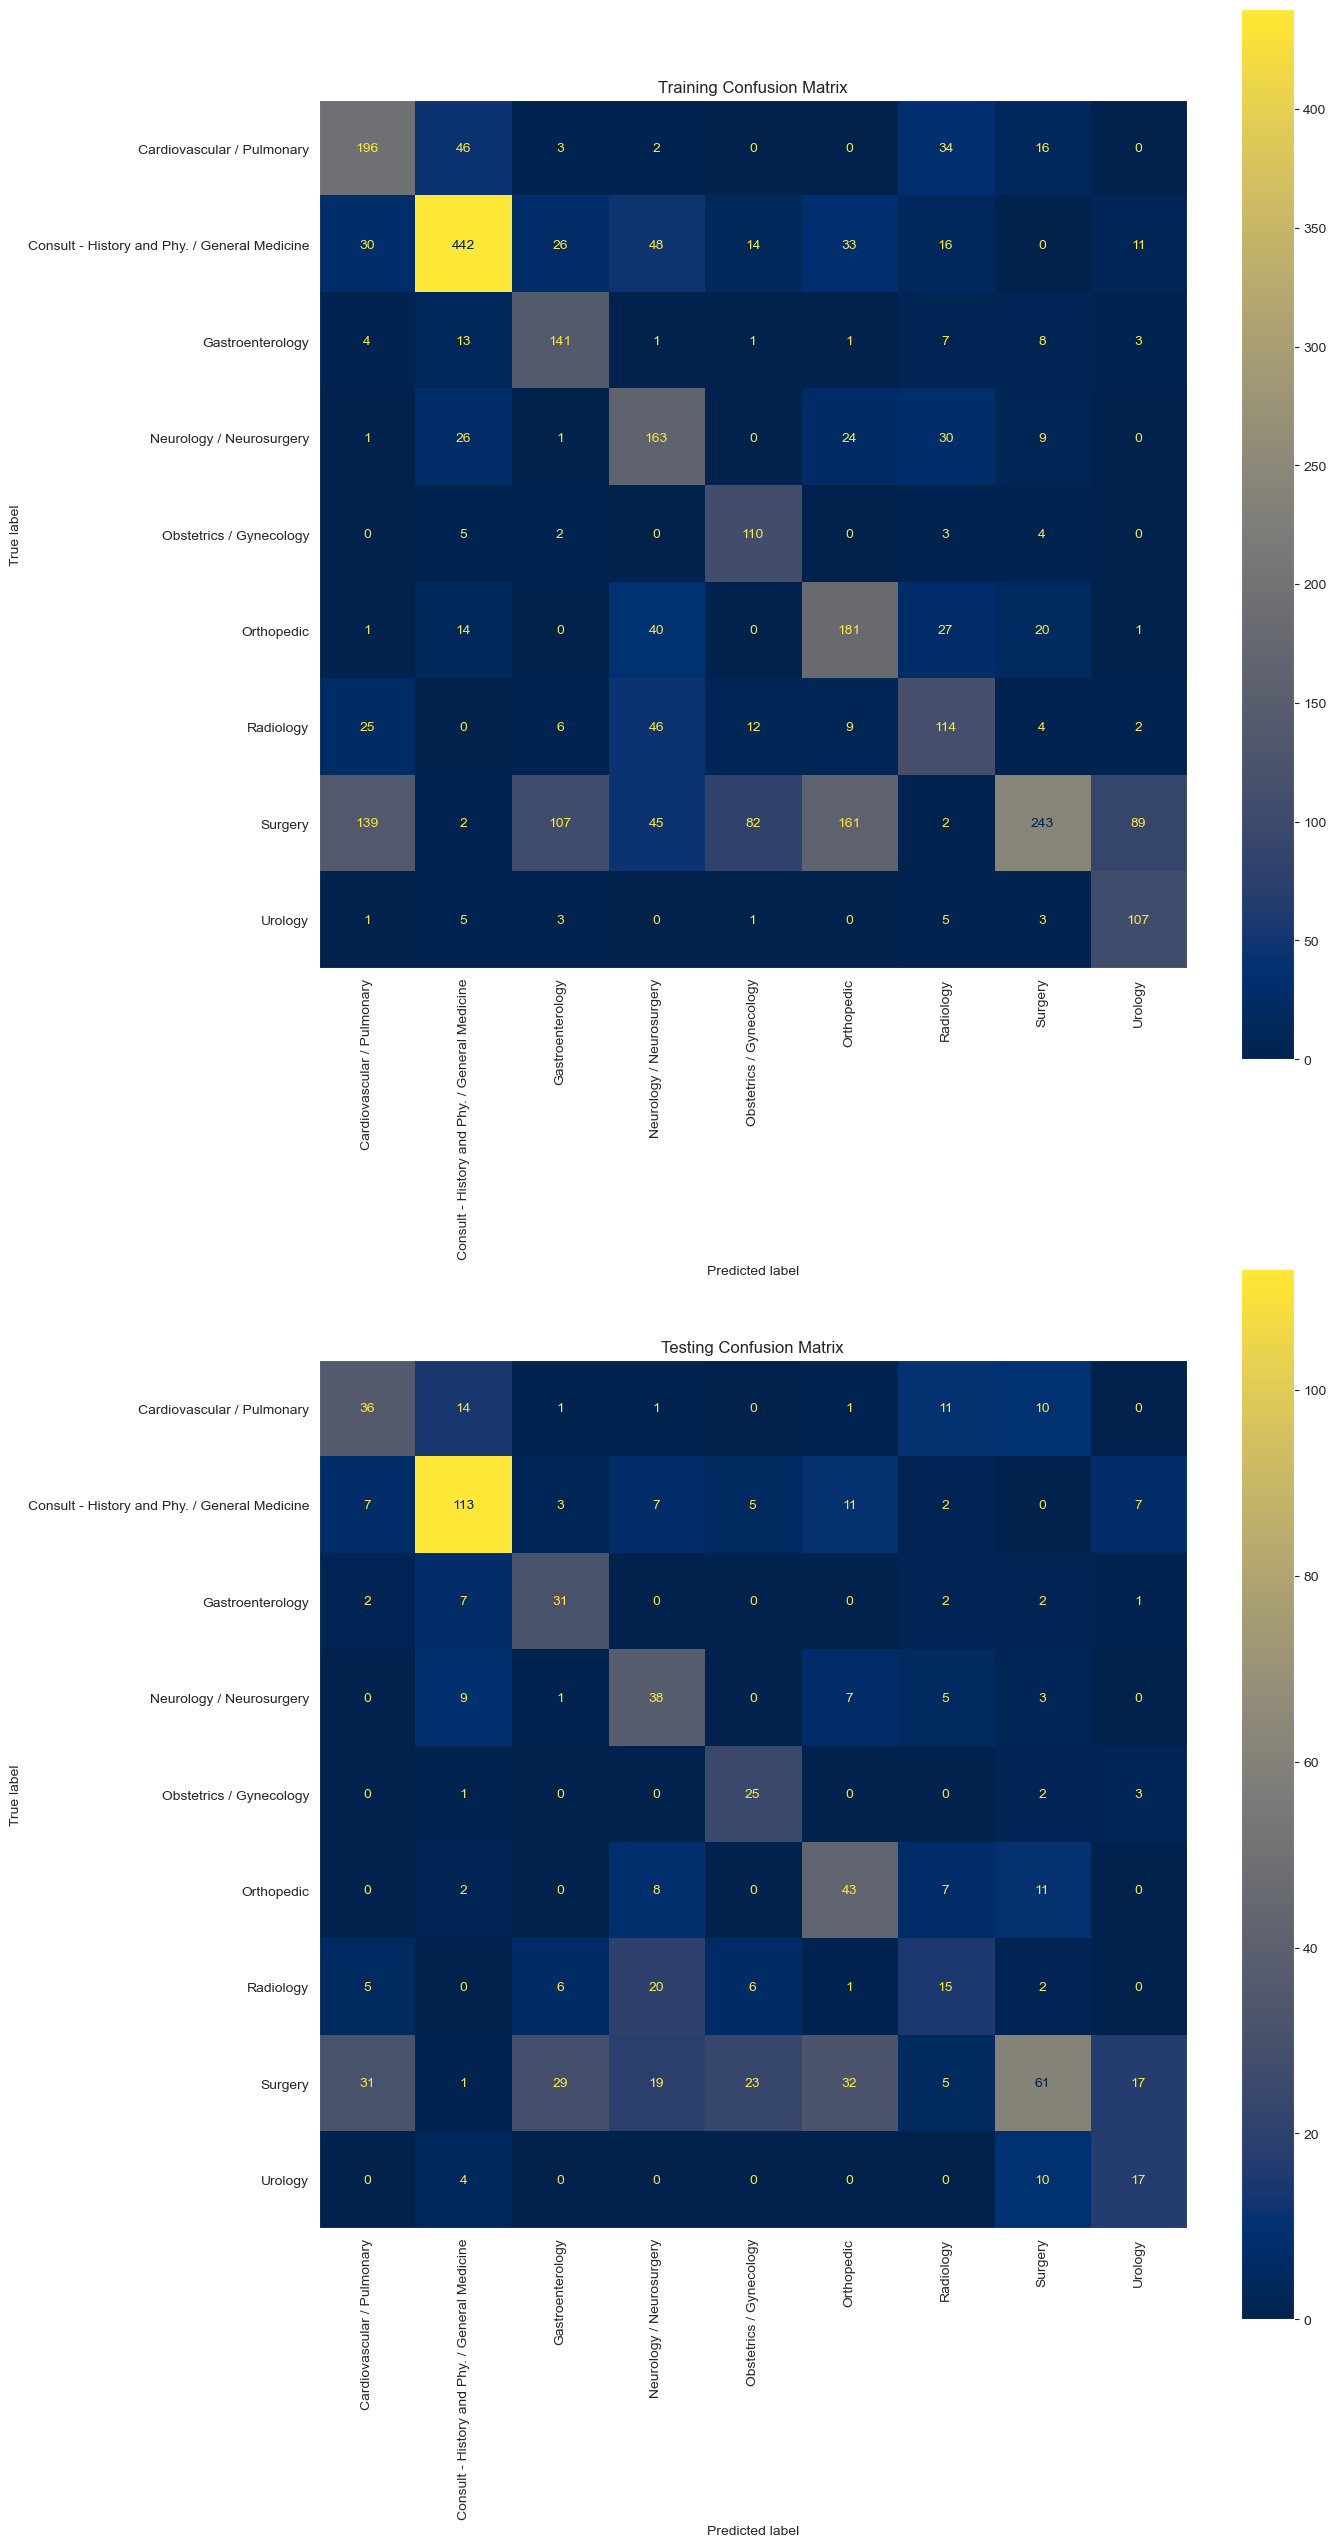

In [579]:
best_cat = evaluate_grid(cat_grid)

# Model Evaluation

In [30]:
#with open('model/best_model.pkl', 'wb') as f:
#    pickle.dump(best_log, f)

In [31]:
with open('model/best_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [35]:
model

Pipeline(steps=[('feat_union',
                 FeatureUnion(transformer_list=[('vec',
                                                 TfidfVectorizer(max_df=0.75,
                                                                 min_df=0.025)),
                                                ('topics',
                                                 Pipeline(steps=[('vec',
                                                                  TfidfVectorizer(max_df=0.75,
                                                                                  min_df=5)),
                                                                 ('nmf',
                                                                  NMF(l1_ratio=0,
                                                                      max_iter=10000,
                                                                      n_components=9,
                                                                      random_state=42))]))])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

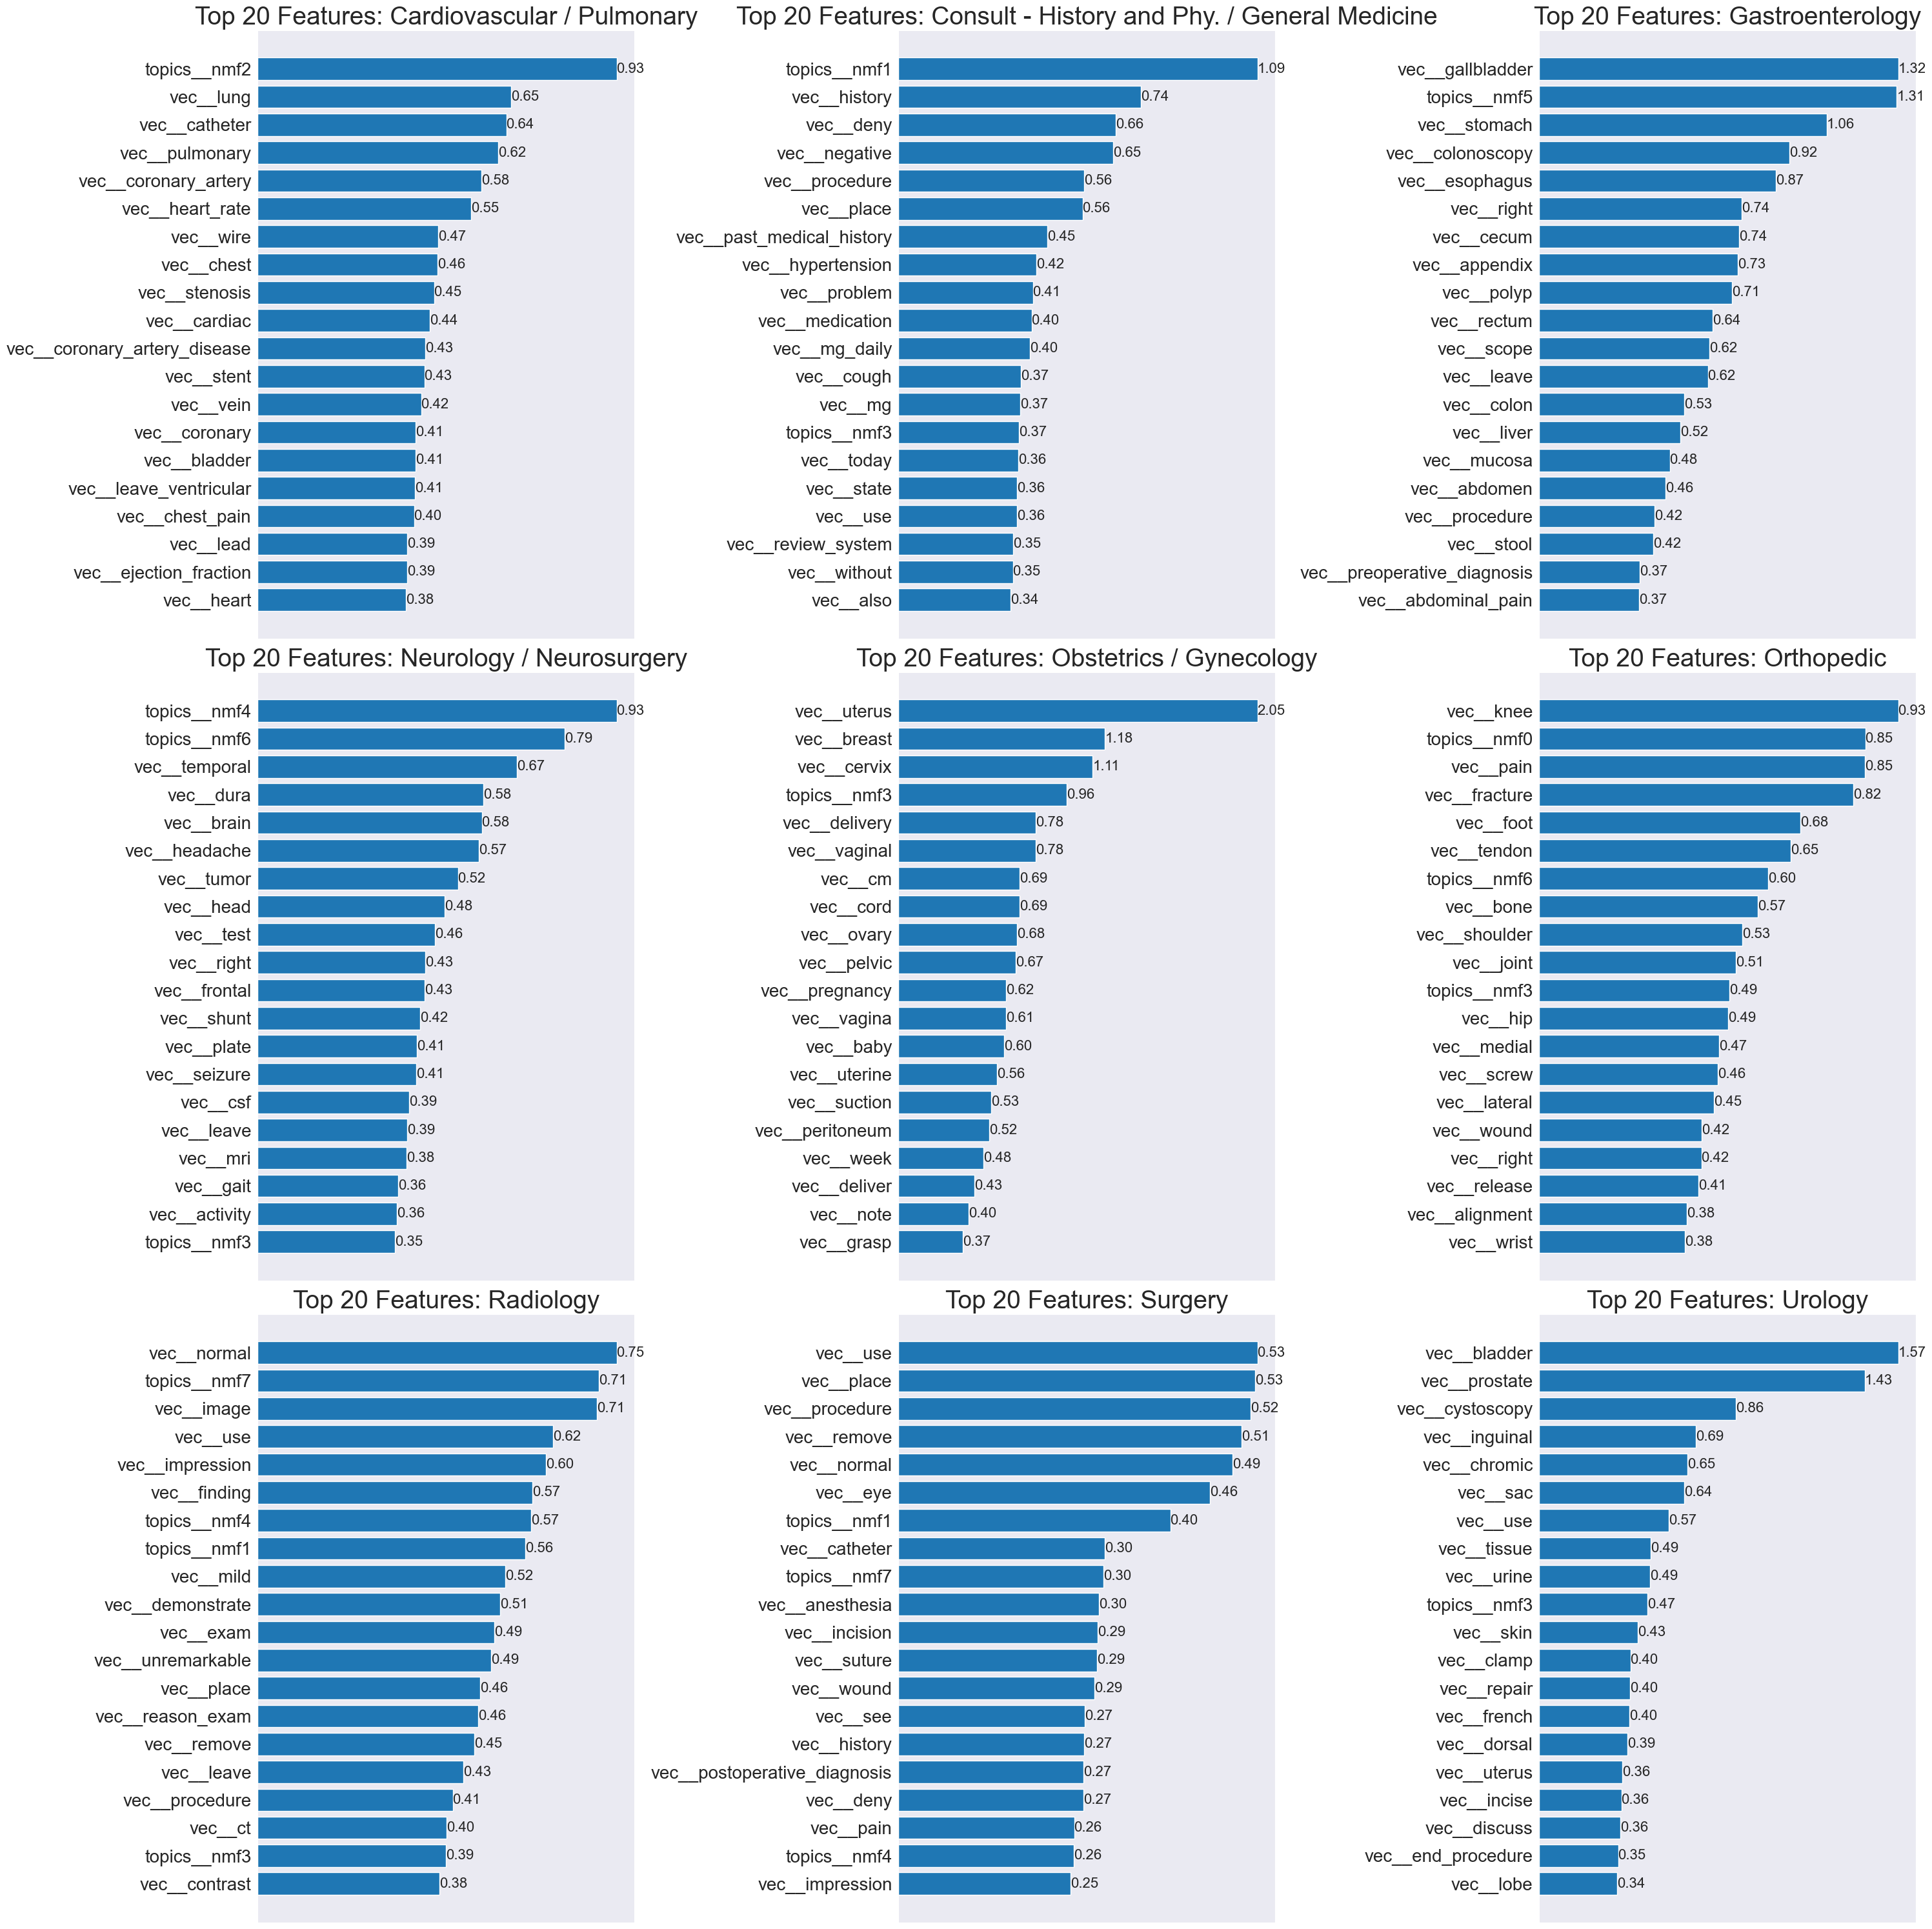

In [111]:
fig, axs = plt.subplots(3, 3, figsize=(30, 30))

# Flatten the axes array so we can iterate over it with a single loop
axs = axs.flatten()

# Iterate over the specialties and call the count_by_spec function for each one
for i, num in enumerate(range(0, len(model[1].coef_))):
    ax = axs[i]
    specs = list(mapping.values())    
    coeff_dict = dict(zip(model[0].get_feature_names_out(),np.abs(model[1].coef_[num])))
    sorted_dict = dict(sorted(coeff_dict.items(), key=lambda x: x[1], reverse=True))
    top_20 = dict(list(sorted_dict.items())[:20])
    ax.barh(range(len(top_20)), list(top_20.values()), align='center')
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(list(top_20.keys()),fontsize=20)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_title(f'Top 20 Features: {specs[num]}',fontsize=28)

    for j, (feat, coef) in enumerate(top_20.items()):
        ax.annotate(f"{coef:.2f}", xy=(coef, j), va='center', fontsize=16)
plt.tight_layout()
plt.savefig('figures/model_features.png')
plt.show()

In [147]:
nmf = model[0].transformer_list[1][1].named_steps['nmf']
vec = model[0].transformer_list[1][1].named_steps['vec']
X_transformed = model[0].transformer_list[1][1][0].transform(X_train['gensim_cleaned'])
vis = pyLDAvis.sklearn.prepare(nmf,X_transformed,vec)
pyLDAvis.save_html(vis, 'figures/my_ldavis.html')
pyLDAvis.display(vis)

/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/evan/miniforge3/envs/tf_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [133]:
model[0].transformer_list[1][1][0]

TfidfVectorizer(max_df=0.75, min_df=5)

In [149]:
from sklearn.utils import estimator_html_repr

with open("figures/pipeline.html", "w") as f:
    f.write(estimator_html_repr(model))

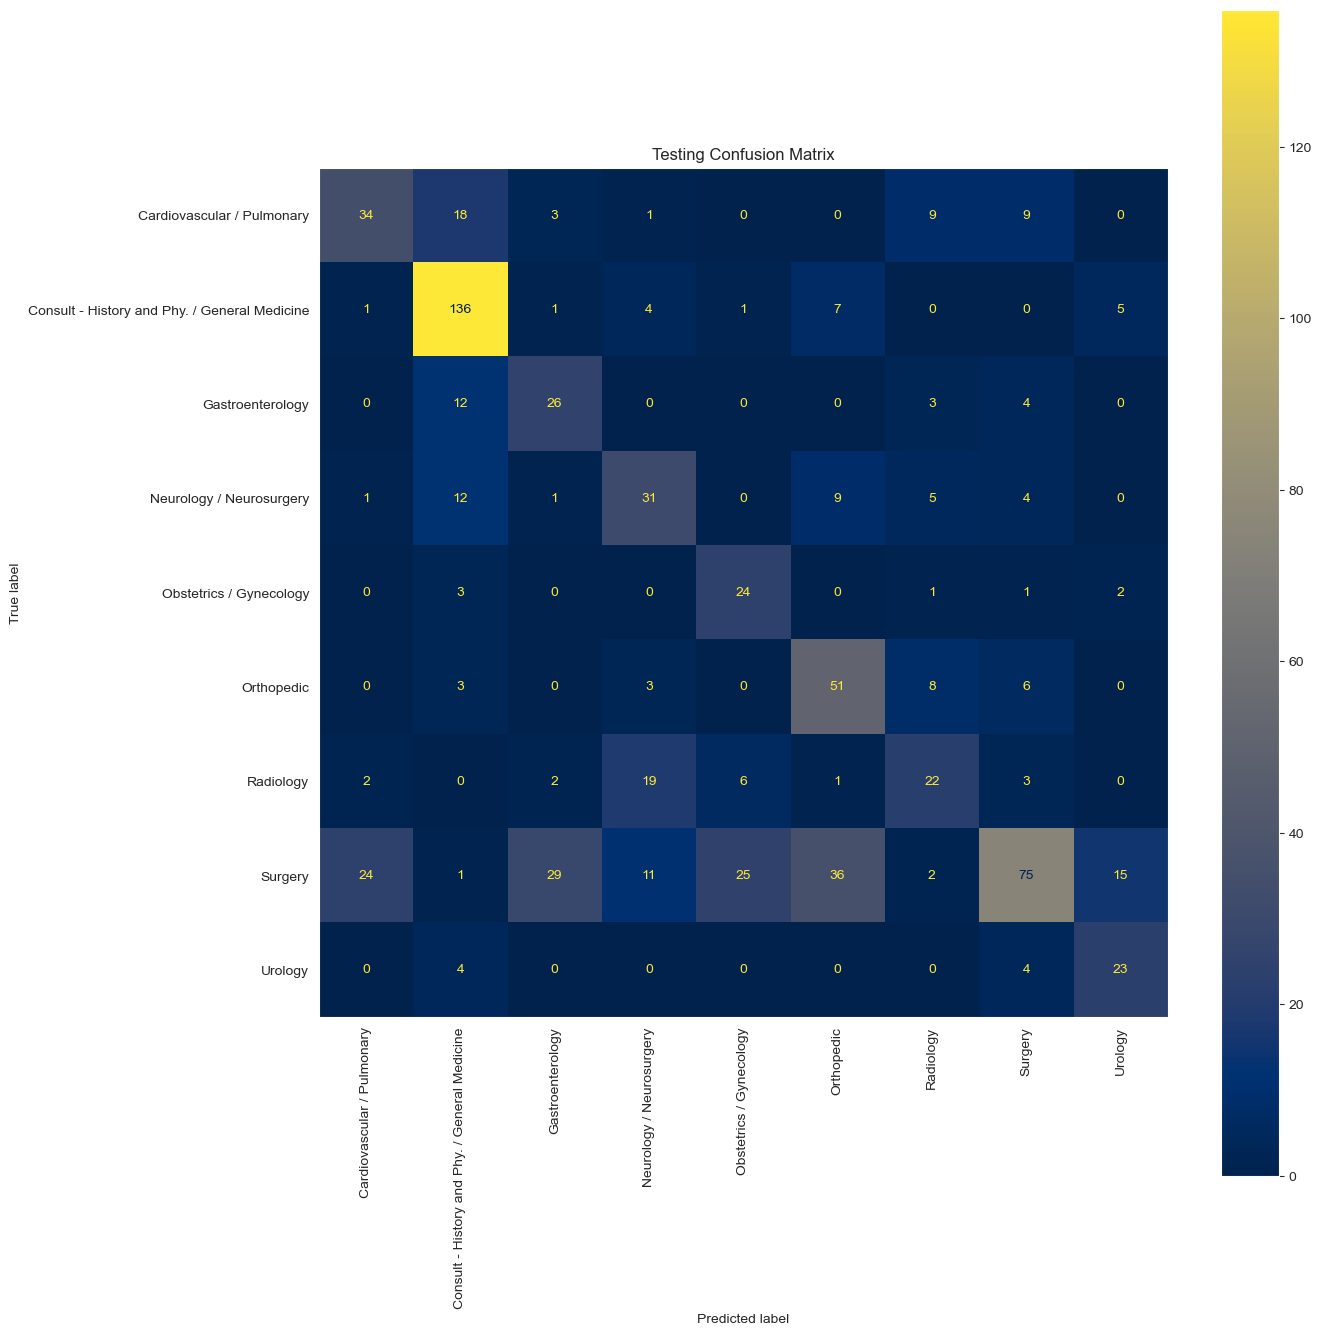

In [164]:
fig, ax = plt.subplots(figsize=(14,14))
plot_confusion_matrix(model,X_test['gensim_cleaned'],y_test,
                      display_labels=mapping.values(),xticks_rotation='vertical',
                     cmap='cividis',ax=ax,values_format='d')
ax.set_title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png');